# Projet 04 : Construisez un modèle de scoring
***

**Contexte** : Notre société "Prêt à dépenser" propose des crédits à la consommation pour des personnes ayant peu ou pas d'historique de prêt.  
**Projet** : Permettre aux chargés de relation client d'accorder ou non un crédit à un prospect/client. J'ai à ma disposition un jeu de données contenant un historique de prêts, un historique d'informations financières et des informations sur le comportement des emprunteurs.  
**Objectif** : Développer un algorithme de classification pour la réalisation d'un outil de scoring. L'outil doit être facilement interprétable et permet de visualiser l'importance des variables impactant la prédiction de l'algorithme.

***
# I) Démarche méthodologique d'analyse de données

Ma démarche s’articule autour de X phases : 
 - l’élaboration d’un dataset d’étude : filtrage, nettoyage et transformation, permettant d’obtenir un dataset d’étude propre pour l’analyse
 - la compréhension du dataset : analyse univariée et multivariée
 - l'analyse de la problématique : choix de la métrique, problème d'équilibrage
 - l'étude des modèles : équilibrage, features importance --> choix du modèle
 - l'utilisation du modèle : optimisation, ajout de variables, ajout de données
 - l'interprétabilité : LIME/SHAPE

# II) Méthodes du projet

Pour ce projet, nous avons défini plusieurs méthodes touchant à l'exploration, au nettoyage, à la transformation et surtout aux différents tests de nos modèles.

In [1]:
# imports du projet
import sys, time, gc
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# méthode pour déterminer les corrélations entre la target et les autres variables
def get_corr_target_var(df, target_label='TARGET', threshold=0.04, top=10):
    result = []
    print("Calcul des corrélations entre la target et les autres variables\n")
    corr_tot = df.corr()[target_label].sort_values(ascending=False)
    corr_tot = pd.DataFrame(corr_tot)
    
    # top des corrélations positives
    corr_pos = corr_tot.loc[(corr_tot[target_label] >= threshold) & (corr_tot[target_label] != 1), :]
    print("Il y a", corr_pos.shape[0], "variables participant positivement à la target. Voici le top", min(top, corr_pos.shape[0]), ":")
    display(corr_pos.head(top))
    
    # top des corrélations négatives
    corr_neg = corr_tot.loc[corr_tot[target_label] <= -threshold, :].sort_values(by=target_label, ascending=True)
    print("Il y a", corr_neg.shape[0], "variables participant négativement à la target. Voici le top", min(top, corr_neg.shape[0]), ":")
    display(corr_neg.head(top))
    
    # concaténation pour resultat final
    corr_neg[target_label] = -corr_neg[target_label]
    concat_list = pd.concat([corr_pos, corr_neg]).sort_values(by=target_label, ascending=False)
    print("Et voici le top", min(top, concat_list.shape[0]), "de la liste complète :")
    display(concat_list.head(min(top, concat_list.shape[0])))
    result = concat_list.index.tolist()
    return result[:top]

In [3]:
# méthodes pour afficher les features importance via les modèles RFC, XGBoost et LGBM
def display_feature_importance(classifier, estimator, features, threshold=[0, 0], top=10):
    importance = False
    # if classifier == 'LogReg':
    #     importance = estimator.coef_[0]
    #     plt.bar([x for x in range(len(importance))], importance)
    if classifier in ('RFC', 'XGBoost', 'LGBM'):
        importance = estimator.feature_importances_
    else:
        print("Le classifier", classifier, "ne peut afficher de feature importance.")

    if importance.any():
        feature_importances = pd.DataFrame({'feature': features, 'importance': importance})
        pd.options.display.float_format = "{:.3f}".format
        top_features = feature_importances.sort_values("importance", ascending=False)
        temp_thr = threshold[1] if classifier == 'LGBM' else threshold[0]
        features_to_plot = top_features.loc[top_features["importance"] >= temp_thr, :][:top]
        print("Voici le top", len(features_to_plot), "des features ayant le plus d'impact sur le modèle.")
        display(features_to_plot.head(top))
        features_to_plot.plot(kind='bar', x="feature")
        plt.show()

In [4]:
# Méthode pour séparer les données par type de colonne
def split_data_num_categ(df):
    result = []
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    dict_col = {
        'numeric': [],
        'category': [],
        'boolean': [],
        'datetime': [],
        'deltatime': []
    }
    
    for col in df.columns:
        if df[col].dtype.name in ('float64', 'int64'):
            dict_col['numeric'].append(col)
        elif df[col].dtype.name in ('object', 'category'):
            dict_col['category'].append(col)
        elif df[col].dtype.name == 'bool':
            dict_col['boolean'].append(col)
        elif df[col].dtype.name == 'datetime64':
            dict_col['datetime'].append(col)
        elif df[col].dtype.name == 'timedelta[ns]':
            dict_col['deltatime'].append(col)
        else:
            print("Type de données non connu :", df[col].dtype.name, "pour la colonne", col)

    print("Voici la répartition des colonnes par type de données :")
    for key, value in dict_col.items():
        nb_col_by_type = len(value)
        if nb_col_by_type > 0:
            print(key, ":", nb_col_by_type, "colonnes, soit", round(nb_col_by_type/df.shape[1]*100, 2), "% des colonnes.")
            result.append(df[value])
    
    return result

In [5]:
# pour les pie charts, pour afficher les pourcentages et les libellés uniquement avec le taux > limit_perc%
limit_perc = 5
def show_perc(pct):
    return ('%.1f%%' % pct) if pct > limit_perc else ''

def show_labels(data):
    list = []
    for val, cnt in data.items():
        if (cnt*100/np.sum(data)) > limit_perc :
            list.append(val)
        else:
            list.append('')
    return list

In [6]:
# Méthode pour l'encoding des variables catégorielles
from sklearn.preprocessing import LabelEncoder
def compute_encoding(df, df2=False):
    result = []
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    df_copy = df.copy()
    
    is_second_df = False
    if df2 and len(df2) > 0:
        is_second_df = True
        df2_copy = df2.copy()
    
    nb_col_orig = len(df_copy.columns)
    print("Le DataFrame à encoder présente", len(df_copy), "lignes et", nb_col_orig, "colonnes.")
    nb_label = 0
    nb_one_hot = 0
    
    # Label Encoder
    label_encoder = LabelEncoder()
    for col in df_copy:
        if df_copy[col].dtype == 'object' and len(list(df_copy[col].unique())) <= 2:
            print("La colonne", col, "est label encodée")
            label_encoder.fit(df_copy[col])
            df_copy[col] = label_encoder.transform(df_copy[col])
            nb_label +=1
            # gestion 2 df (train et test)
            if is_second_df:
                df2_copy[col] = label_encoder.transform(df2_copy[col])
                
    # One-Hot Encoder
    nb_one_hot = len(df_copy.select_dtypes('object').apply(pd.Series.nunique, axis = 0))
    df_copy = pd.get_dummies(df_copy)
    if is_second_df:
        df2_copy = pd.get_dummies(df2_copy)
    
    print("Il y a eu", nb_label, "colonnes ayant eu le LabelEncoder.")
    print("Il y a eu", nb_one_hot, "colonnes ayant eu le One-Hot Encoder.")
    nb_col_actual = len(df_copy.columns)
    print("Une fois encodé, le DataFrame présente", len(df_copy), "lignes et", len(df_copy.columns), "colonnes.")
    time_plus_col = round(nb_col_actual/nb_col_orig, 1)
    print("Le Dataframe présente maintenant", time_plus_col, "fois plus de colonnes.")
    return df_copy, df2_copy if is_second_df else df2

In [7]:
# Méthode pour imputer et scaler nos données de ce projet
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
def impute_and_scale(train_set, test_set):
    # copie des 2 sets avant de les retourner modifiés
    train = train_set.copy()
    test = test_set.copy()

    # Imputer
    imputer = SimpleImputer(strategy = 'median')
    # Scaler
    scaler = MinMaxScaler(feature_range = (0, 1))

    # on fit l'imputer avec le trainning set uniquement
    imputer.fit(train)
    # on impute sur les 2 sets
    train = imputer.transform(train)
    test = imputer.transform(test)

    # on fait la même chose pour le scaler
    scaler.fit(train)
    train = scaler.transform(train)
    test = scaler.transform(test)

    return train, test

In [8]:
def display_confusion_matrix(y_true, y_pred, display_labels=None):
    print("Calcul et affichage de la matrice de confusion")
    # pour calculer la matrice de confusion
    cm = metrics.confusion_matrix(y_true, y_pred)
    cm = cm.T
    # pour afficher la matrice de confusion
    displ = metrics.ConfusionMatrixDisplay(cm, display_labels=display_labels)
    displ.plot()
    displ.ax_.xaxis.tick_top()
    displ.ax_.xaxis.set_label_position('top') 
    plt.xlabel('Actual Label')
    plt.ylabel('Predicted Label')
    plt.gcf().axes[0].tick_params()
    plt.gcf().axes[1].tick_params()
    plt.show()

In [9]:
def display_classification_report(y_true, y_pred, display_labels=None):
    print("Calcul et affichage du rapport de classification")
    clf_report = metrics.classification_report(y_true, y_pred, target_names=display_labels)
    print(clf_report)

In [10]:
def plot_roc_curve(model_name, y_test, y_test_pred):  
    print("Calcul et affichage de la courbe ROC")
    [fpr_te, tpr_te, thr_te] = metrics.roc_curve(y_test, y_test_pred)
    plt.plot(fpr_te, tpr_te, color='coral', lw=2, label="")
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('1 - Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    plt.title("ROC du classifier {}".format(model_name))

In [11]:
def display_classification_metrics(estimator, X_test, y_test, y_test_pred, list_metrics=["accuracy"], all_metrics=False, roc_curve=False, beta=1):
    print("Calcul et affichage des différentes métriques")
    if all_metrics:
        list_metrics = ["accuracy", "recall", "precision", "auc", "f1", "fbeta"]
    for met in list_metrics:
        if met == "accuracy":
            te_res = metrics.accuracy_score(y_test, y_test_pred).round(3)
            print("Accuracy :", te_res)
        elif met == "precision":     
            te_res = metrics.precision_score(y_test, y_test_pred, average='macro').round(3)
            print("Précision :", te_res)
        elif met == "recall":  
            te_res = metrics.recall_score(y_test, y_test_pred, average='macro').round(3)
            print("Recall :", te_res)
        elif met == "auc":    
            te_res = metrics.roc_auc_score(y_test, y_test_pred, average='macro').round(3)
            print("AUC :", te_res)
            if roc_curve:
                plot_roc_curve(type(estimator).__name__, y_test, y_test_pred)
        elif met == "f1":   
            te_res = metrics.f1_score(y_test, y_test_pred, average='macro').round(3)
            print("F1-score :", te_res)
        elif met == "fbeta":
            te_res = metrics.fbeta_score(y_test, y_test_pred, beta=beta, average='macro').round(3)
            print("Fbeta-score (beta=", beta,  ") :", te_res)
        else:
            print("La métrique", met, "n'est pas dans la liste suivante accuracy, recall, precision, auc, f1 et fbeta. Veuillez vérifier la saisie.")

In [12]:
def get_estimator(classifier='dummy', balance_method=False):
    result = False
    print("Import de l'estimateur demandé")
    
    if 'sklearn' not in sys.modules:
        print("Le module Scikit-learn n'est pas installé et ne peut donc être utilisé.")
    else:
        if classifier == 'dummy':
            from sklearn import dummy
            return dummy.DummyClassifier()
        elif classifier == 'LogReg':
            from sklearn import linear_model
            return linear_model.LogisticRegression()
        elif classifier == 'KNN':
            from sklearn import neighbors
            return neighbors.KNeighborsClassifier()
        elif classifier == 'RFC':
            from sklearn import ensemble
            return ensemble.RandomForestClassifier(class_weight="balanced")
        elif classifier == 'XGBoost':
            from sklearn import ensemble
            return ensemble.GradientBoostingClassifier()
    
    if classifier == "LGBM":
        try:
            from lightgbm import LGBMClassifier
            return LGBMClassifier(class_weight="balanced")
        except:
            print("Le module LightGBM n'est pas installé et ne peut donc être utilisé.")
    
    return result

In [13]:
def compute_smote_data(X_train, y_train):
    from imblearn.over_sampling import SMOTE #, SMOTENC

    smote = SMOTE()
    X_smote, y_smote = smote.fit_resample(X_train, y_train)
    return X_smote, y_smote
    
    # smotenc = SMOTENC()
    # X_smotenc, y_smotenc = smotenc.fit_resample(X_train_std, y_train)=

In [14]:
def compute_X_default_classifier(X_train, y_train, X_test, y_test, classifier='dummy', balance_method=False):
    result = False
    print("Entraînement et prédiction du classifier", classifier)
    
    estimator = get_estimator(classifier, balance_method=balance_method)
    
    classes_weights = None
    if balance_method:
        if balance_method == "SMOTE":
            print("Avec la méthode SMOTE d'équilibrage.")
            X_train, y_train = compute_smote_data(X_train, y_train)
        elif balance_method == "class_weight" and classifier == 'XGBoost':
            print("Avec la méthode class_weight d'équilibrage.")
            from sklearn.utils import class_weight
            classes_weights = class_weight.compute_sample_weight(
                class_weight='balanced',
                y=y_train
            )
    
    estimator.fit(X_train, y_train, sample_weight=classes_weights)
    y_pred = estimator.predict(X_test)
    result = estimator, y_pred
            
    return result

In [15]:
# méthode pour faire un one-hot encoding peu importe le nombre de valeurs uniques
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [16]:
# Méthode de préprocessing pour charger le fichier POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('input/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    
    # on ne l'utilisera pas dans notre projet
    pos.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    
    # pour définir les aggrégations spécifiques à certaines colonnes
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    # pour définir les aggrégations pour les autres colonnes restantes
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    # on regroupe toutes les lignes avec le même id pour effectuer les opérations d'aggrégation
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    
    # on compte le nombre de lignes avec le même id
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [17]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('input/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    
    # on ne l'utilisera pas dans notre projet
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    
    # aggrégation pour toutes les données numériques
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    
    # on compte le nombre de lignes avec le même id
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

***
# III) Présentation générale du jeu de données

In [18]:
raw_data = pd.read_csv('input/application_train.csv')
print("Le dataset brut présente", raw_data.shape[0], "lignes et", raw_data.shape[1], "colonnes")
raw_data.head()

Le dataset brut présente 307511 lignes et 122 colonnes


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Le dataset présente beaucoup de colonnes. Pour améliorer les temps de traitement de nos modèles, nous devons rédire le nombre de colonnes.  
Donc, avant même de commencer à imputer des valeurs en traitant les valeurs manquantes et les outliers, nous allons effectuer différents filtrages de colonnes.

***
## 1) Traitements de filtrage des données

Pour mener à bien ce traitement, nous devons d'abord distinguer les variables numériques des variables catégorielles.

In [19]:
# On regarde la répartition des colonnes en fonction de leur type
data_num, data_categ = split_data_num_categ(raw_data)

Voici la répartition des colonnes par type de données :
numeric : 106 colonnes, soit 86.89 % des colonnes.
category : 16 colonnes, soit 13.11 % des colonnes.


### a) Sélection des variables catégorielles pertinentes

Commençons par regarder les variables catégorielles : 

In [20]:
print(data_categ.columns)

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')


En voyant cette liste, je vois plusieurs variables qui peuvent être supprimées :
 - `WEEKDAY_APPR_PROCESS_START` : le jour de la semaine où le client à contracté le prêt
 - `FLAG_OWN_CAR` : renseigne si le client a une voiture ou non

In [21]:
col_to_drop = ["WEEKDAY_APPR_PROCESS_START", "FLAG_OWN_CAR"]

Par ailleurs, pour la colonne `CODE_GENDER`, nous avons 4 lignes dont la valeur est XNA. Cela signifie que la valeur n'est pas définie. L'impact sur les modèles est négligeable et cela va simplifier l'encoding. Nous supprimons donc ces 4 lignes.

In [22]:
raw_data = raw_data.loc[raw_data["CODE_GENDER"] != 'XNA', :]
raw_data.reset_index(drop=True)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307503,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307504,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307505,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### b) Sélection des variables numériques pertinentes

Continuons en regardant les variables numériques : 

In [23]:
print(data_num.columns)

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=106)


Nous pouvons distinguer les colonnes commençant par `FLAG_` qui semblent nombreuses. Elles représentent des valeurs pouvant être 0 ou 1.

In [24]:
col_w_flag = [x for x in data_num.columns if x.startswith("FLAG_")]
print(col_w_flag)

['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']


On peut voir que ces variables indiquent si le client a un numéro de téléphone et s'il a fourni certains documents. Sans trop de risque, je considère que ces données ne seront pas utiles à nos modèles. Nous pouvons les supprimer.

In [25]:
col_to_drop = col_to_drop + col_w_flag

Regardons maintenant les colonnes restantes :

In [26]:
col_wo_flag = [x for x in data_num.columns if not x.startswith("FLAG_")]
print(col_wo_flag)

['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_

En voyant cette liste, je vois plusieurs variables qui peuvent être supprimées :
 - `DAYS_LAST_PHONE_CHANGE` : nombre de jours depuis le dernier changement de téléphone du client
 - `HOUR_APPR_PROCESS_START` : heure à laquelle le client a contracté le prêt
 - `OWN_CAR_AGE` : à quel âge le client a obtenu sa voiture

In [27]:
col_to_drop = col_to_drop + ["DAYS_LAST_PHONE_CHANGE", "HOUR_APPR_PROCESS_START", "OWN_CAR_AGE"]

### c) Suppression des variables numériques par corrélation

Afin de réduire d'avantage le nombre de colonne, regardons les corrélations fortes entre variables.

In [28]:
col_to_examine = [x for x in raw_data.columns if x not in col_to_drop]
data_num, data_categ = split_data_num_categ(raw_data.loc[:, col_to_examine])

Voici la répartition des colonnes par type de données :
numeric : 77 colonnes, soit 84.62 % des colonnes.
category : 14 colonnes, soit 15.38 % des colonnes.


In [29]:
# extraire les variables étant très corrélées > 0.8
corr_thre = 0.8
print("Etudions les corrélations fortes, càd > 0.8, entre les différentes variables numériques.")
list_col_num = [x for x in data_num.columns if x not in col_to_drop]
corr = raw_data[list_col_num].corr().values
nb_col = len(list_col_num)
nb_correl = 0
list_col_stat_correl = []
for i in range(nb_col):
    for j in range(i+1, nb_col):
        if abs(corr[i,j]) >= corr_thre:
            # print(list_col_num[i], ' ', list_col_num[j], ' ', corr[i,j])
            nb_correl += 1
            if list_col_num[i].endswith(('_AVG', '_MODE', '_MEDI')):
                list_col_stat_correl.append(list_col_num[i])
            if list_col_num[j].endswith(('_AVG', '_MODE', '_MEDI')):
                list_col_stat_correl.append(list_col_num[j])
                
list_col_stat_correl = list(set(list_col_stat_correl))
print("Il y a un total", nb_correl, "paires de corrélation.")
print("A noter, qu'il y a", len(list_col_stat_correl), "colonnes de statistiques.")

Etudions les corrélations fortes, càd > 0.8, entre les différentes variables numériques.
Il y a un total 111 paires de corrélation.
A noter, qu'il y a 43 colonnes de statistiques.


On observe une tendance avec des colonnes représentants des statistiques. On les reconnait car finissent par _AVG, _MODE et _MEDI. Commençons par traiter ces variables pour y voir plus claire dans celles qui restent.

In [30]:
# faisons la liste des préfixes avec la liste de leur suffixe concernant les variables statistiques
list_col_stat_correl.sort()
dict_col_stat = {}
for col in list_col_stat_correl:
    temp_col = col.split('_')
    if len(temp_col) == 2:
        temp_key = temp_col[0]
    elif len(temp_col) == 3:
        temp_key = temp_col[0] + "_" + temp_col[1]
    else:
        break
    if temp_key in dict_col_stat:
        dict_col_stat[temp_key].append(temp_col[-1])
    else:
        dict_col_stat[temp_key] = [temp_col[-1]]

In [31]:
# dans un dataframe pour que ce soit plus lisible
data_col_stat = pd.DataFrame.from_dict(dict_col_stat, orient="index")
print("Voici la liste des colonnes classées par préfixe avec leurs occurences de statistiques :")
data_col_stat

Voici la liste des colonnes classées par préfixe avec leurs occurences de statistiques :


,0,1,2
APARTMENTS,AVG,MEDI,MODE
BASEMENTAREA,AVG,MEDI,MODE
COMMONAREA,AVG,MEDI,MODE
ELEVATORS,AVG,MEDI,MODE
ENTRANCES,AVG,MEDI,MODE
FLOORSMAX,AVG,MEDI,MODE
FLOORSMIN,AVG,MEDI,MODE
LANDAREA,AVG,MEDI,MODE
LIVINGAPARTMENTS,AVG,MEDI,MODE
LIVINGAREA,AVG,MEDI,MODE


Pour presque toutes ces variables, nous avons les 3 statistiques. Nous allons garder la médiane (_MEDI) et supprimer les 2 autres. En revanche, pour TOTALAREA, on ne fait rien.

In [32]:
# pour faire la liste des variables avec les 2 suffixe que l'on souhaite
col_corr_to_drop = [["{}_AVG".format(key), "{}_MODE".format(key)] for key, value in dict_col_stat.items() if len(value) == 3]
# pour flatten la liste
col_corr_to_drop = [item for sublist in col_corr_to_drop for item in sublist]

Regardons maintenant les variables correllées restantes.

In [33]:
# extraire les variables étant très corrélées > 0.8
list_col_num = [x for x in list_col_num if x not in col_corr_to_drop]
corr = raw_data[list_col_num].corr().values
nb_col = len(list_col_num)
nb_correl = 0
list_col_stat_correl = []
for i in range(nb_col):
    for j in range(i+1, nb_col):
        if abs(corr[i,j]) >= 0.8:
            print(list_col_num[i], ' ', list_col_num[j], ' ', corr[i,j])
            nb_correl += 1
                
print("Il reste", nb_correl, "paires de corrélation.")

CNT_CHILDREN   CNT_FAM_MEMBERS   0.8791590620719116
AMT_CREDIT   AMT_GOODS_PRICE   0.9869705054221515
REGION_RATING_CLIENT   REGION_RATING_CLIENT_W_CITY   0.950841651907527
REG_REGION_NOT_WORK_REGION   LIVE_REGION_NOT_WORK_REGION   0.8606266975786437
REG_CITY_NOT_WORK_CITY   LIVE_CITY_NOT_WORK_CITY   0.8255741759890748
APARTMENTS_MEDI   ELEVATORS_MEDI   0.8374465762624632
APARTMENTS_MEDI   LIVINGAPARTMENTS_MEDI   0.9424846083809705
APARTMENTS_MEDI   LIVINGAREA_MEDI   0.9159465183880083
APARTMENTS_MEDI   TOTALAREA_MODE   0.8865671821598489
ELEVATORS_MEDI   LIVINGAPARTMENTS_MEDI   0.8142173293806912
ELEVATORS_MEDI   LIVINGAREA_MEDI   0.8683399950453738
ELEVATORS_MEDI   TOTALAREA_MODE   0.8380269845588266
LIVINGAPARTMENTS_MEDI   LIVINGAREA_MEDI   0.8846891205281778
LIVINGAPARTMENTS_MEDI   TOTALAREA_MODE   0.8461037989753682
LIVINGAREA_MEDI   TOTALAREA_MODE   0.9193626710377817
OBS_30_CNT_SOCIAL_CIRCLE   OBS_60_CNT_SOCIAL_CIRCLE   0.9984894522942417
DEF_30_CNT_SOCIAL_CIRCLE   DEF_60_CNT_SO

On peut maintenant faire un choix manuellement.  
**Garder** : AMT_CREDIT, REGION_RATING_CLIENT, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, LIVINGAREA_MEDI, CNT_CHILDREN, REG_REGION_NOT_WORK_REGION, REG_CITY_NOT_WORK_CITY  
**Supprimer** : AMT_GOODS_PRICE, REGION_RATING_CLIENT_W_CITY, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, APARTMENTS_MEDI, LIVINGAPARTMENTS_MEDI, TOTALAREA_MODE, CNT_FAM_MEMBERS, LIVE_REGION_NOT_WORK_REGION, LIVE_CITY_NOT_WORK_CITY, ELEVATORS_MEDI

In [34]:
col_corr_to_drop = col_corr_to_drop + [
    "AMT_GOODS_PRICE", "REGION_RATING_CLIENT_W_CITY", "OBS_60_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE", "APARTMENTS_MEDI", "LIVINGAPARTMENTS_MEDI",
    "TOTALAREA_MODE", "CNT_FAM_MEMBERS", "LIVE_REGION_NOT_WORK_REGION", "LIVE_CITY_NOT_WORK_CITY", "ELEVATORS_MEDI"
]

In [35]:
col_tot_to_drop = col_to_drop + col_corr_to_drop
data_drop_col = raw_data.drop(col_tot_to_drop, axis=1)

In [36]:
print("Après le traitement de suppression des colonnes, nous supprimons", len(col_tot_to_drop), "colonnes, soit", round(len(col_tot_to_drop)/len(raw_data.columns)*100, 1), "% des colonnes.")
print("Maintenant notre dataset présente", data_drop_col.shape[0], "lignes et", data_drop_col.shape[1], "colonnes")

Après le traitement de suppression des colonnes, nous supprimons 70 colonnes, soit 57.4 % des colonnes.
Maintenant notre dataset présente 307507 lignes et 52 colonnes


***
## 2) Traitements de nettoyage des données

Maintenant que notre dataset est plus restreint, nous allons pouvoir effectuer nos traitements de nettoyage des données.

In [37]:
data_num, data_categ = split_data_num_categ(data_drop_col)

Voici la répartition des colonnes par type de données :
numeric : 38 colonnes, soit 73.08 % des colonnes.
category : 14 colonnes, soit 26.92 % des colonnes.


### a) Traitement des valeurs manquantes

Commençons par le traitement des valeurs manquantes avec les colonnes de type catégoriel.

In [38]:
# on regarde la répartition des colonnes en fonction de la part de valeurs manquantes
valeurs_manquantes = round(data_drop_col[data_categ.columns].isnull().mean()*100, 4).sort_values(ascending=False)
missing_val_df = pd.DataFrame(valeurs_manquantes, columns = ["%"])
col_w_miss_val = missing_val_df.loc[missing_val_df["%"] > 0, :]
print("Voici la liste des variables catégorielles classées par taux de valeurs manquantes.")
col_w_miss_val.head(len(col_w_miss_val))

Voici la liste des variables catégorielles classées par taux de valeurs manquantes.


,%
FONDKAPREMONT_MODE,68.3864
WALLSMATERIAL_MODE,50.8411
HOUSETYPE_MODE,50.1764
EMERGENCYSTATE_MODE,47.3986
OCCUPATION_TYPE,31.3453
NAME_TYPE_SUITE,0.4202


In [39]:
nb_miss_categ = data_drop_col[data_categ.columns].isnull().sum().sum()
nb_tot_data = data_drop_col.shape[0] * len(data_drop_col.columns)
print("Pour les variables catégorielles, il manque", nb_miss_categ , "entrées, soit", round(nb_miss_categ/nb_tot_data*100, 2), "% des données totales.")

Pour les variables catégorielles, il manque 764364 entrées, soit 4.78 % des données totales.


Pour chacune de ces variables, plusieurs constats : 
 - je ne suis pas capable de savoir si elles seront pertinentes ou non pour notre étude, donc je dois les garder dans un premier temps
 - je ne peux remplacer les valeurs manquantes par une méthode quelconque (plus fréquent, kmeans...) car cela déséquilibrerait les données

Je choisis donc de remplacer toutes ces valeurs manquantes par la valeur "Other".

In [40]:
for col in col_w_miss_val.index:
    data_drop_col[col].fillna("Other", inplace=True)

***
Regardons maintenant les variables numériques.

In [41]:
# voici la répartition des données manquantes pour les données numériques
miss_num = round(data_drop_col[data_num.columns].isnull().mean()*100, 4).sort_values(ascending=False)
miss_num_df = pd.DataFrame(miss_num, columns = ["%"])
print("Voici la liste des variables numériques classées par taux de valeurs manquantes.")
miss_num_df.loc[miss_num_df["%"] != 0, :].head(len(miss_num_df))

Voici la liste des variables numériques classées par taux de valeurs manquantes.


,%
COMMONAREA_MEDI,69.8722
NONLIVINGAPARTMENTS_MEDI,69.4332
FLOORSMIN_MEDI,67.8489
YEARS_BUILD_MEDI,66.4980
LANDAREA_MEDI,59.3769
BASEMENTAREA_MEDI,58.5164
EXT_SOURCE_1,56.3812
NONLIVINGAREA_MEDI,55.1792
ENTRANCES_MEDI,50.3491
LIVINGAREA_MEDI,50.1937


In [42]:
nb_miss_num = data_drop_col[data_num.columns].isnull().sum().sum()
print("Pour les variables numériques, il manque", nb_miss_num , "entrées, soit", round(nb_miss_num/nb_tot_data*100, 2), "% des données totales.")

Pour les variables numériques, il manque 2472080 entrées, soit 15.46 % des données totales.


Pour les mêmes raisons que pour les variables de type catégoriel, je ne vais pas pouvoir remplir les valeurs manquantes de manière pertinente. Pour la suite de notre étude, j'utiliserai un SimpleImputer, par la médiane, pour remplir les données manquantes.  
Cependant, je dois effectuer cette imputation après le split des données.

### b) Traitement des outliers

Continuons par le traitement des outliers.

In [43]:
print("Voici la liste de toutes les valeurs numériques avec leurs informations respectives.")
data_drop_col.describe().transpose()

Voici la liste de toutes les valeurs numériques avec leurs informations respectives.


,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307507.0,278181.527256,102790.132982,1.000020e+05,189146.500000,278203.000000,367143.500000,4.562550e+05
TARGET,307507.0,0.080730,0.272420,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
CNT_CHILDREN,307507.0,0.417047,0.722119,0.000000e+00,0.000000,0.000000,1.000000,1.900000e+01
AMT_INCOME_TOTAL,307507.0,168797.685779,237124.627320,2.565000e+04,112500.000000,147150.000000,202500.000000,1.170000e+08
AMT_CREDIT,307507.0,599028.596733,402492.601859,4.500000e+04,270000.000000,513531.000000,808650.000000,4.050000e+06
AMT_ANNUITY,307495.0,27108.666786,14493.798379,1.615500e+03,16524.000000,24903.000000,34596.000000,2.580255e+05
REGION_POPULATION_RELATIVE,307507.0,0.020868,0.013831,2.900000e-04,0.010006,0.018850,0.028663,7.250800e-02
DAYS_BIRTH,307507.0,-16037.027271,4363.982424,-2.522900e+04,-19682.000000,-15750.000000,-12413.000000,-7.489000e+03
DAYS_EMPLOYED,307507.0,63815.929208,141276.472519,-1.791200e+04,-2760.000000,-1213.000000,-289.000000,3.652430e+05
DAYS_REGISTRATION,307507.0,-4986.131376,3522.883030,-2.467200e+04,-7479.500000,-4504.000000,-2010.000000,0.000000e+00


Tout semble en ordre pour la plupart des colonnes dans la mesure où, n'étant pas du métier, je ne vois rien de remarquable.  
En revanche, nous allons nous pencher sur les variables commençant par DAYS_. Nous allons les convertir en année pour mieux nous rendre compte si tout va bien. A noter que les valeurs sont en négatif.

In [44]:
# traitement sur les variables commençant par DAYS_
col_days = [x for x in data_num.columns if x.startswith("DAYS_")]
for col in col_days:
    temp_col = col.removeprefix('DAYS_')
    temp_col = "Y_{}".format(temp_col)
    data_drop_col[temp_col] = abs(data_drop_col[col] / 365.25)
col_days_y = [x for x in data_drop_col.columns if (x.startswith("DAYS_") | x.startswith("Y_"))]
print("Voici la liste des variables ayant l'unité DAYS, ainsi que leur conversion en unité YEARS.")
data_drop_col[col_days_y].describe()

Voici la liste des variables ayant l'unité DAYS, ainsi que leur conversion en unité YEARS.


,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,Y_BIRTH,Y_EMPLOYED,Y_REGISTRATION,Y_ID_PUBLISH
count,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000
mean,-16037.027271,63815.929208,-4986.131376,-2994.201670,43.906988,185.422505,13.651284,8.197677
std,4363.982424,141276.472519,3522.883030,1509.454566,11.947933,381.778150,9.645128,4.132661
min,-25229.000000,-17912.000000,-24672.000000,-7197.000000,20.503765,0.000000,0.000000,0.000000
25%,-19682.000000,-2760.000000,-7479.500000,-4299.000000,33.984942,2.554415,5.503080,4.709103
50%,-15750.000000,-1213.000000,-4504.000000,-3254.000000,43.121150,6.075291,12.331280,8.908966
75%,-12413.000000,-289.000000,-2010.000000,-1720.000000,53.886379,15.624914,20.477755,11.770021
max,-7489.000000,365243.000000,0.000000,0.000000,69.073238,999.980835,67.548255,19.704312


On ne repère qu'une seule anomalie. Pour les années d'emploi ou ancienneté, on observe des valeurs à 1000. Nous faisons l'approximation que ces valeurs représentent les personnes sans emploi.  
On cale plutôt la valeur à 0. Par ailleurs, nous créons une nouvelle colonne signifiant si la personne est sans emploi ou non.

In [45]:
# flag sans emploi
data_drop_col.loc[data_drop_col["Y_EMPLOYED"] > 999, 'FLAG_UNEMPLOYED'] = 'Y'
data_drop_col.loc[data_drop_col["Y_EMPLOYED"] < 999, 'FLAG_UNEMPLOYED'] = 'N'

# remplace valeur abérrantes par 0
data_drop_col.loc[data_drop_col['FLAG_UNEMPLOYED'] == 'Y', 'DAYS_EMPLOYED'] = 0
data_drop_col.loc[data_drop_col['FLAG_UNEMPLOYED'] == 'Y', 'Y_EMPLOYED'] = 0

In [46]:
nb_unemployed = len(data_drop_col.loc[data_drop_col['FLAG_UNEMPLOYED'] == 'Y', :])
print("Il y a", nb_unemployed, "prêts attribués à des personnes sans emploi soit,", round(nb_unemployed/data_drop_col.shape[0]*100, 1), "% des données.")

Il y a 55374 prêts attribués à des personnes sans emploi soit, 18.0 % des données.


Dans un souci de compréhension, nous allons supprimer les colonnes DAYS_ et garder les colonnes Y_.

In [47]:
# suppression des colonnes commençant par DAYS_
data_drop_col_days = data_drop_col.drop(col_days, axis=1)

***
# IV Compréhension du dataset

## 1) Shape du dataset d'étude

In [48]:
# Bilan sur le dataset d'étude
data_study = data_drop_col_days
print("Notre dataset d'étude présente", data_study.shape[0], "lignes et", data_study.shape[1], "colonnes")
print("Par rapport à notre dataset brut, nous avons gardé", round(data_study.shape[0]/raw_data.shape[0]*100, 100), "% de lignes et", round(data_study.shape[1]/raw_data.shape[1]*100, 2), "% de colonnes.")
print("En revanche, nous avons supprimé", round((1-data_study.shape[0]/raw_data.shape[0])*100, 2), "% de lignes et", round((1-data_study.shape[1]/raw_data.shape[1])*100, 2), "% de colonnes.")

Notre dataset d'étude présente 307507 lignes et 53 colonnes
Par rapport à notre dataset brut, nous avons gardé 100.0 % de lignes et 43.44 % de colonnes.
En revanche, nous avons supprimé 0.0 % de lignes et 56.56 % de colonnes.


In [49]:
# On regarde la répartition des colonnes en fonction de leur type
data_num, data_categ = split_data_num_categ(data_study)

Voici la répartition des colonnes par type de données :
numeric : 38 colonnes, soit 71.7 % des colonnes.
category : 15 colonnes, soit 28.3 % des colonnes.


## 2) Analyse univariée

Afin d'avoir une meilleure compréhension de notre dataset, nous effectuons maintenant une analyse univariée. Nous allons nous concentrer sur les variables notables suivantes : 
 - `AMT_CREDIT` : montant du crédit emprunté
 - `Y_BIRTH` : âge du client au moment de contracter l'emprunt
 - `Y_EMPLOYED` : ancienneté du client à son travail
 - `CODE_GENDER` : le client est un homme ou une femme
 - `NAME_FAMILY_STATUS` : status marital du client

Montant du prêt
Moyenne :  599029.0 $


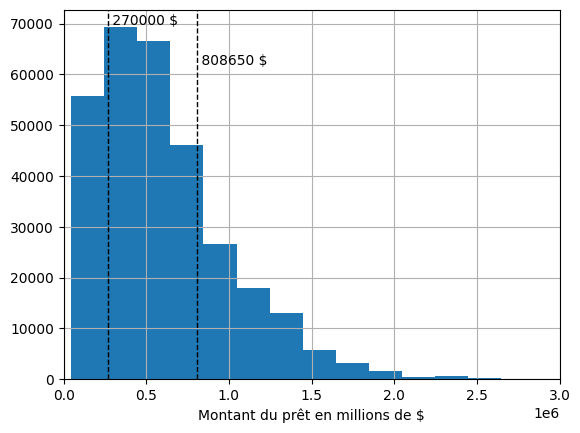

In [50]:
print("Montant du prêt")
print("Moyenne : ", round(data_study["AMT_CREDIT"].mean(), 0), "$")
quartiles = [np.percentile(data_study["AMT_CREDIT"], p) for p in [25, 75]]
data_study["AMT_CREDIT"].hist(bins=20)
plt.xlabel("Montant du prêt en millions de $")
# pour tracer les 1er et 3ème quartiles
min_ylim, max_ylim = plt.ylim()
plt.axvline(quartiles[0], color='k', linestyle='dashed', linewidth=1)
plt.text(quartiles[0], max_ylim*0.96, ' {:.0f} $'.format(quartiles[0]))
plt.axvline(quartiles[1], color='k', linestyle='dashed', linewidth=1)
plt.text(quartiles[1], max_ylim*0.85, ' {:.0f} $'.format(quartiles[1]))
plt.xlim((0, 3000000))
plt.show()

In [51]:
# Montant prêt > 1 million
nb_sup_million = data_study.loc[data_study["AMT_CREDIT"] >= 1000000, :]
print("Les clients ayant un prêt d'un montant supérieur à 1 million de dollars représentent", round(len(nb_sup_million)/len(data_study)*100, 1), "% du total.")

Les clients ayant un prêt d'un montant supérieur à 1 million de dollars représentent 16.3 % du total.


Âge du client
Moyenne :  44.0 ans


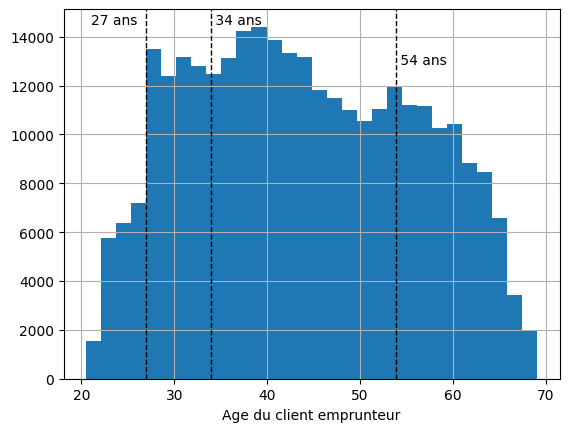

In [52]:
print("Âge du client")
print("Moyenne : ", round(data_study["Y_BIRTH"].mean(), 0), "ans")
quartiles = [np.percentile(data_study["Y_BIRTH"], p) for p in [25, 75]]
data_study["Y_BIRTH"].hist(bins=30)
plt.xlabel("Age du client emprunteur")
# pour tracer les 1er et 3ème quartiles
min_ylim, max_ylim = plt.ylim()
plt.axvline(27, color='k', linestyle='dashed', linewidth=1)
plt.text(21, max_ylim*0.96, '27 ans')
plt.axvline(quartiles[0], color='k', linestyle='dashed', linewidth=1)
plt.text(quartiles[0], max_ylim*0.96, ' {:.0f} ans'.format(quartiles[0]))
plt.axvline(quartiles[1], color='k', linestyle='dashed', linewidth=1)
plt.text(quartiles[1], max_ylim*0.85, ' {:.0f} ans'.format(quartiles[1]))
plt.show()

In [53]:
# Age du client < 27 ans
nb_inf_age = data_study.loc[data_study["Y_BIRTH"] <= 27, :]
print("Les clients âgés de moins de 27 ans représentent", round(len(nb_inf_age)/len(data_study)*100, 1), "% du total.")

# Age du client > 60 ans
nb_sup_age = data_study.loc[data_study["Y_BIRTH"] >= 60, :]
print("Les clients âgés de plus de 60 ans représentent", round(len(nb_sup_age)/len(data_study)*100, 1), "% du total.")

Les clients âgés de moins de 27 ans représentent 6.8 % du total.
Les clients âgés de plus de 60 ans représentent 11.5 % du total.


Ancienneté dans l'entreprise
Moyenne :  5.0 ans


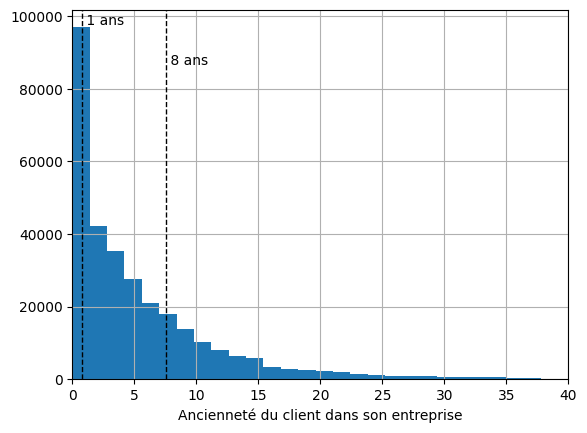

In [54]:
print("Ancienneté dans l'entreprise")
print("Moyenne : ", round(data_study["Y_EMPLOYED"].mean(), 0), "ans")
quartiles = [np.percentile(data_study["Y_EMPLOYED"], p) for p in [25, 75]]
data_study["Y_EMPLOYED"].hist(bins=35)
plt.xlabel("Ancienneté du client dans son entreprise")
# pour tracer les 1er et 3ème quartiles
min_ylim, max_ylim = plt.ylim()
plt.axvline(quartiles[0], color='k', linestyle='dashed', linewidth=1)
plt.text(quartiles[0], max_ylim*0.96, ' {:.0f} ans'.format(quartiles[0]))
plt.axvline(quartiles[1], color='k', linestyle='dashed', linewidth=1)
plt.text(quartiles[1], max_ylim*0.85, ' {:.0f} ans'.format(quartiles[1]))
plt.xlim((0, 40))
plt.show()

In [55]:
# Ancienneté au travail > 10 ans
nb_sup_empl = data_study.loc[data_study["Y_EMPLOYED"] >= 10, :]
print("Les clients ayant une ancienneté en entreprise de plus de 10 ans représentent", round(len(nb_sup_empl)/len(data_study)*100, 1), "% du total.")

Les clients ayant une ancienneté en entreprise de plus de 10 ans représentent 16.6 % du total.


Répartition des clients par genre


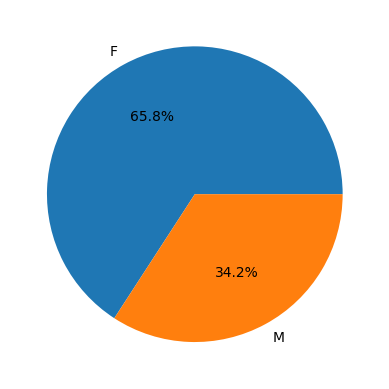

In [56]:
print("Répartition des clients par genre")
temp_val_count = data_study["CODE_GENDER"].value_counts(normalize=True)
temp_val_count.plot(kind="pie", autopct=show_perc, labels=show_labels(temp_val_count), label='')
plt.show()

On remarque que le genre du client est déséquilibré avec une proportion de 2/3 de femmes.

Répartition des clients par situation familiale


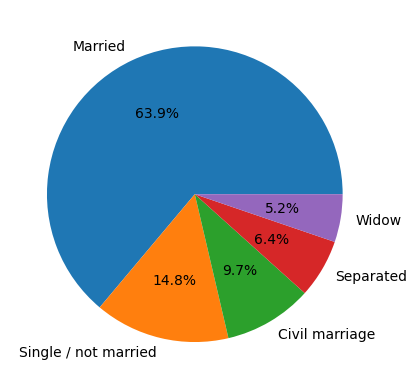

In [57]:
print("Répartition des clients par situation familiale")
temp_val_count = data_study["NAME_FAMILY_STATUS"].value_counts(normalize=True)
temp_val_count.plot(kind="pie", autopct=show_perc, labels=show_labels(temp_val_count), label='')
plt.show()

On remarque que plus de 60% des clients sont mariés.

## 3) Analyse multivariée

Maintenant que nous avons une meilleure compréhension de notre dataset, nous allons regarder le lien existant entre 2 variables en particulier :
 - `AMT_CREDIT` : le montant du prêt contracté
 - `AMT_ANNUITY` : le montant des annuités du prêt

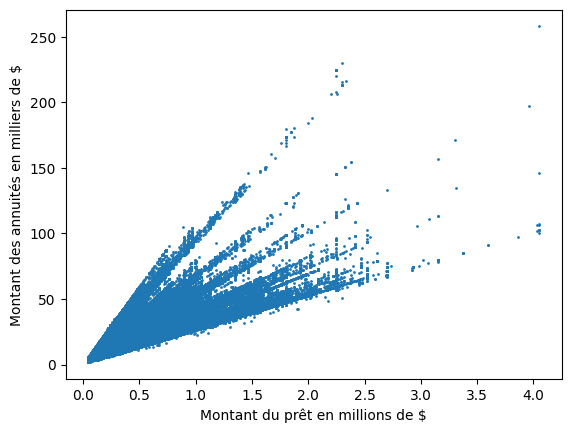

In [58]:
plt.scatter(data_study["AMT_CREDIT"]/1000000,data_study["AMT_ANNUITY"]/1000, s=1)
plt.xlabel("Montant du prêt en millions de $")
plt.ylabel("Montant des annuités en milliers de $")
plt.show()

On peut effectivement remarquer une certaines corrélation entre le montant du crédit et le paiement de ses annuités. Comme prévu, globalement, plus le montant du crédit est élevé, plus les annuités sont élevées. On observe cependant, différentes tendances probablement dues aux différences de revenus.

***
# V) Analyse de la problématique

Nous allons maintenant passer à l'analyse de la problématique en faisant différentes approches métier.

## 1) Encoding des variables catégorielles

Maintenant que nous avons une meilleure compréhension du dataset, nous pouvons traiter les variables catégorielles pour l'étude des modèles. Cela signifie que nous devons les encoder pour n'avoir que des variables numériques dans notre dataset.

In [59]:
# Liste des variables catégorielles avec leur nombre de valeurs unique
print("Voici la liste des variables catégorielles classées selon leur nombre décroissant de valeurs unique.")
data_categ.apply(pd.Series.nunique, axis = 0).sort_values(ascending=False)

Voici la liste des variables catégorielles classées selon leur nombre décroissant de valeurs unique.


ORGANIZATION_TYPE      58
OCCUPATION_TYPE        19
NAME_TYPE_SUITE         8
NAME_INCOME_TYPE        8
WALLSMATERIAL_MODE      8
NAME_FAMILY_STATUS      6
NAME_HOUSING_TYPE       6
NAME_EDUCATION_TYPE     5
FONDKAPREMONT_MODE      5
HOUSETYPE_MODE          4
EMERGENCYSTATE_MODE     3
NAME_CONTRACT_TYPE      2
CODE_GENDER             2
FLAG_OWN_REALTY         2
FLAG_UNEMPLOYED         2
dtype: int64

Pour ce projet, nous allons faire les choix suivants : 
 - variables ayant 2 valeurs uniques : on fera un Label Encoding qui remplacera les valeurs par 1 ou 0 arbitrairement
 - variables ayant plus de 2 valeurs uniques : on utilisera le One-Hot Encoding qui créera autant de colonne que de valeur unique possible

In [60]:
data_encode, data_encode2 = compute_encoding(data_study)

Le DataFrame à encoder présente 307507 lignes et 53 colonnes.
La colonne NAME_CONTRACT_TYPE est label encodée
La colonne CODE_GENDER est label encodée
La colonne FLAG_OWN_REALTY est label encodée
La colonne FLAG_UNEMPLOYED est label encodée
Il y a eu 4 colonnes ayant eu le LabelEncoder.
Il y a eu 11 colonnes ayant eu le One-Hot Encoder.
Une fois encodé, le DataFrame présente 307507 lignes et 172 colonnes.
Le Dataframe présente maintenant 3.2 fois plus de colonnes.


## 2) Etude de la target

D'après notre cahier des charges, la target a les valeurs suivantes : 
 - 1 : le client a des difficultés de paiement, càd a eu des retard de paiement plus de X jours durant au moins un des premiers Y versements du crédit (X et Y ne sont malheureusement pas précisés)
 - 0 : dans tous les autres cas

***
Voyons ce que nous pouvons apprendre de plus sur notre target en regardant sa répartition dans le dataset.

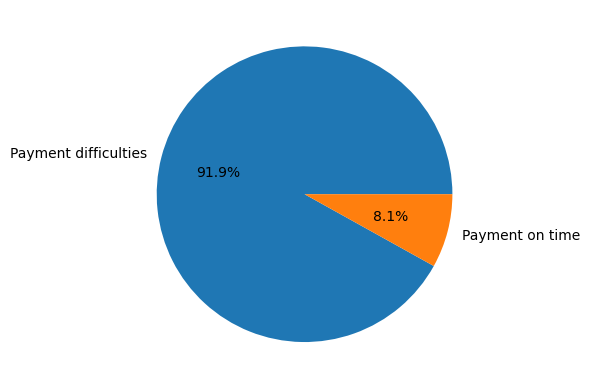

In [171]:
temp_val_count = raw_data['TARGET'].value_counts(normalize=True)
temp_val_count = temp_val_count.rename(index={1: 'Payment on time', 0: 'Payment difficulties'})
temp_val_count.plot(kind="pie", autopct=show_perc, labels=temp_val_count.index, label='')
plt.show()

On remarque un déséquilibre dans cette répartition. Nous devrons le prendre en compte dans notre étude en attribuant notamment un poids pour chaque valeur.

***
Regardons maintenant les corrélations entre la target et les autres variables.

In [62]:
col_corr_target = get_corr_target_var(data_encode, top=15)

Calcul des corrélations entre la target et les autres variables

Il y a 8 variables participant positivement à la target. Voici le top 8 :


,TARGET
REGION_RATING_CLIENT,0.058901
NAME_INCOME_TYPE_Working,0.057483
CODE_GENDER,0.054710
REG_CITY_NOT_WORK_CITY,0.050992
NAME_EDUCATION_TYPE_Secondary / secondary special,0.049822
REG_CITY_NOT_LIVE_CITY,0.044394
OCCUPATION_TYPE_Laborers,0.043017
EMERGENCYSTATE_MODE_Other,0.041390


Il y a 14 variables participant négativement à la target. Voici le top 14 :


,TARGET
EXT_SOURCE_3,-0.178926
EXT_SOURCE_2,-0.160471
EXT_SOURCE_1,-0.155317
Y_BIRTH,-0.078242
NAME_EDUCATION_TYPE_Higher education,-0.056593
Y_ID_PUBLISH,-0.051457
NAME_INCOME_TYPE_Pensioner,-0.046211
Y_EMPLOYED,-0.046050
FLAG_UNEMPLOYED,-0.045989
ORGANIZATION_TYPE_XNA,-0.045989


Et voici le top 15 de la liste complète :


,TARGET
EXT_SOURCE_3,0.178926
EXT_SOURCE_2,0.160471
EXT_SOURCE_1,0.155317
Y_BIRTH,0.078242
REGION_RATING_CLIENT,0.058901
NAME_INCOME_TYPE_Working,0.057483
NAME_EDUCATION_TYPE_Higher education,0.056593
CODE_GENDER,0.054710
Y_ID_PUBLISH,0.051457
REG_CITY_NOT_WORK_CITY,0.050992


Les corrélations ne sont pas fortes, mais nous voyons des tendances avec les variables suivantes classées par ordre d'importance : 
 - `EXT_SOURCE_1`, `EXT_SOURCE_2` et `EXT_SOURCE_3` : données venant de sources extérieures
 - `Y_BIRTH` : âge du client au moment de la souscription
 - `REGION_RATING_CLIENT` : note donnée par HomeCredit pour la région où vit le client
 - `NAME_INCOME_TYPE_Working` : si les revenus du client proviennent de son travail
 - `NAME_EDUCATION_TYPE_Higher education` : si le client a un niveau d'étude supérieur
 - `CODE_GENDER` : le genre du client
 - `Y_ID_PUBLISH` : le nombre de jours depuis lequel le client a changé sa carte d'identité
 - `REG_CITY_NOT_WORK_CITY` : si le client a une adresse permanente correspondante à l'adresse de son travail ou pas
 - `NAME_EDUCATION_TYPE_Secondary / secondary special` : si le client a un niveau d'étude secondaire
 - `NAME_INCOME_TYPE_Pensioner` : si les revenus du client proviennent d'une pension
 - `Y_EMPLOYED` et `FLAG_UNEMPLOYED` : l'ancienneté du client à son travail et donc s'il travaille
 - `ORGANIZATION_TYPE_XNA` : si le client travaille dans une organisation de type non défini

***
L'un des points les plus important est de choisir quelle métrique nous devons évaluer pour mener à bien notre projet. Pour cela, étudions d'abord la matrice de confusion suivante : 

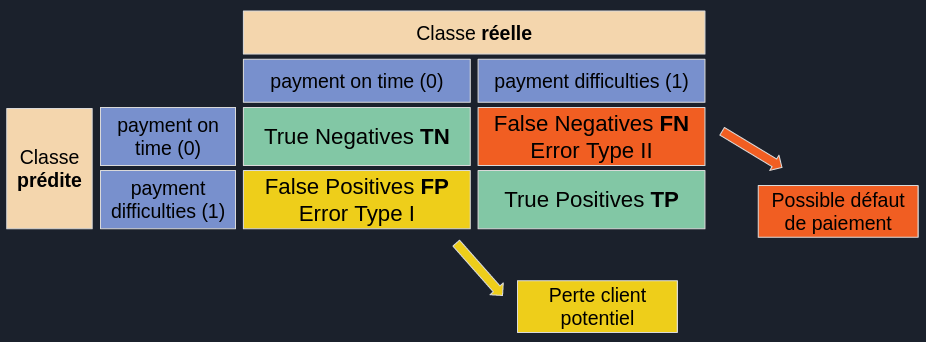

En fonction de la valeur de la target, nous pouvons répartir les détections ainsi. Bien évidemment, les vraies détections (positives TP ou négatives TN) sont ce que l'on souhaite. Cependant, comme tout modèle de prédiction, nous allons également obtenir de fausses détections : 
 - False Negatives FN : le client a eu des difficultés de paiement, mais nous avons prédit qu'il n'en avait pas. Se fier au modèle entraîner un possible défaut de paiement en accordant le prêt.
 - False Positives FP : le client n'a pas eu de difficultés de paiement, mais nous avons prédit qu'il en avait. Si on se fie au modèle, nous pouvons perdre un client potentiel en lui refusant son prêt.

Pour notre société, le plus dangereux est les FN car ce ne sera pas bon pour nos revenus. Néanmoins, notre but étant de faire du chiffre, nous ne pouvons passer à côté de clients potentiels matérialisés par les FP. On souhaiterai donc en priorité minimiser les FN, et dans l'idéal minimiser les FN et FP. Regardons alors les métriques issues de cette matrice de confusion : 

<font size="3"><center>RECALL (Rappel)</center></font>|<font size="3"><center>PRECISION (Précision)</center></font>
:-|:-
$$Recall = \displaystyle \frac{TP}{TP + FN}$$|$$Precision = \displaystyle \frac{TP}{TP + FP}$$
<font size="2">Le recall renseigne sur la proportion de positifs que l'on a correctement identifiés.</font>|<font size="2">La precision renseigne sur la proportion de prédictions de TP parmi les target que l'on a prédit positifs.</font>
<font size="2">Si on cherche à maximiser cette métrique, nous minimiserons le nombre de FN. Ce qui correspond à notre objectif majeur.</font>|<font size="2">Si on cherche à maximiser cette métrique, nous minimiserons le nombre de FP. Ce qui correspond à notre objectif secondaire.</font>

Il y a cependant une métrique permettant de faire un compromis entre les deux précédentes. La moyenne harmonique est appelée F1-score : 
$$F1-score = \displaystyle 2*\frac{Precision*Recall}{Precision+Recall}$$
ou encore $$F1-score = \displaystyle \frac{2TP}{2TP+FP+FN}$$

Si on cherche à maximiser cette métrique, on pourra à la fois minimiser les FP et les FN. Cette solution est la meilleure si on veut à la fois écarter le danger et ne pas perdre de clients potentiels.
Pour notre étude, nous regardons donc le Recall et le F1-score afin de choisir le meilleur modèle.

Nous pouvons aller plus loin en attribuant un poids pour chacun. Les FN étant plus problématique que les FP, nous pouvons leur donner plus de poids dans une métrique, le Fbeta-Score : 
$$F\beta-score = \displaystyle (1+\beta^2)*\frac{Precision*Recall}{\beta^2*Precision+Recall}$$
ou encore $$F\beta-score = \displaystyle \frac{(1+\beta^2)*TP}{(1+\beta^2)*TP+\beta^2*FP+FN}$$

beta est va de 0 à l'infini. Une utilisation classique est de choisir les valeurs suivantes : 
 - beta = 2 pour que le recall aie plus de poids que la precision
 - beta = 0.5 pour que la precision aie plus de poids que le recall

Dans notre cas, on veut donc un beta supérieur à 1. A savoir que les crédits rapporte à une banque environ 30% de son montant. mais si le client a des difficultés de paiement, il y a potentiellement une perte de tout le montant. Je pense que l'on peut opter pour un beta de 10.

Pour notre étude, nous regardons donc le Recall, le F1-score et le Fbeta-score afin de choisir le meilleur modèle.

## 3) Choix du modèle et de ses hyperparamètres

Pour cette partie, on commence par séparer le jeu de données en jeu d'entraînement (70%) et en jeu de test (30%). On utlise le paramètre permettant d'obtenir des données ayant la même proportion de valeurs de target (92%-8%).

In [63]:
# split des données
data = data_encode
X = data.loc[:, data.columns != "TARGET"]
y = data["TARGET"]

# on split avec le stratify pour obtenir la même répartition de valeurs de target (ie 92-8 %)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Ensuite, on impute des données pour les valeurs manquantes et on normalise les données entre 0 et 1. Ceci permet de réduire l'amplitude pour chaque variable, empêchant ainsi les valeurs importantes d'impacter trop les modèles.

A noter que l'entraînement des méthodes d'imputation et de normalisation est fait sur le jeu d'entraînement. Puis ces modèles sont utlisés tels quel sur le jeu de test.

In [64]:
#  on impute les données manquantes et on standardise les données
X_train_std, X_test_std = impute_and_scale(X_train, X_test)

In [65]:
target_labels = ["payment on time", "payment difficulties"]
features = [x for x in list(data.columns) if x != 'TARGET']
param_metrics = {
    # 'displays': ['confusion_matrix', 'classification_report', 'classification_metrics'],
    'list_metrics': ["accuracy", "recall", "auc", "f1", "fbeta"],
    'all_metrics': False,
    'roc_curve': True,
    'beta': 10
}

### a) Test de classificateur simple

Dans un premier temps, nous allons tester différents classificateurs pour évaluer les plus intéressantes pour notre projet : 
 - Dummy Classifier
 - Logistic Regression
 - KNN
 - RandomForestClassifier
 - XGBoost
 - Light GBM

In [66]:
# Ici aussi, nous commentonos le code pour éviter la trop longue attente
# les résultats sont compilés dans le tableau suivant
# for classifier in ['dummy', 'LogReg', 'KNN', 'RFC', 'XGBoost', 'LGBM']:
#     print("-"*70)
#     print("Calcul du classifier", classifier, "en cours...")
#     estimator, y_pred = compute_X_default_classifier(X_train_std, y_train, X_test_std, y_test, classifier=classifier)
#     # display_confusion_matrix(y_test, y_pred, display_labels=target_labels)
#     display_classification_report(y_test, y_pred, display_labels=target_labels)
#     display_classification_metrics(estimator, X_test, y_test, y_pred, **param_metrics)
#     print("-"*70)

Nous pouvons résumer nos résultats dans le tableau suivant : 
||Dummy Classifier|Logistic Regression|KNN (k=5)|RandomForestClassifier|XGBoost|LightGBM|
|-:|-:|-:|-:|-:|-:|-:|
|Accuracy|0.919|0.919|0.914|0.919|0.920|0.920|
|Recall|0.500|0.504|0.504|0.500|0.505|0.507|
|F1-Score|0.479|0.488|0.491|0.480|0.490|0.493|
|F10-Score|0.500|0.503|0.505|0.500|0.504|0.505|

Pour rappel, ces classificateurs ont les paramètres par défaut. Etant donné ces résultats, nous allons continuer avec les modèles XGBoost et LightGBM. Ils sont les plus intéressants lorsque l'on regarde nos métriques.  
Maintenant que nous avons sélectionné des modèles avec une base de résultat, occupons nous de notre problème de déséquilibre de target.

### b) Equilibrage

Pour équilibrer notre dataset, nous avons accès à 2 méthodes : 
 - class_weight : donne plus de poids sur la target minoritaire
 - SMOTE : crée des données supplémentaires dans les alentours de la target minoritaire

In [67]:
# code commenté pour éviter la longue attente
# for classifier in ['XGBoost', 'LGBM']:
#     print("-"*70)
#     print("Calcul du classifier", classifier, "en cours...")
#     estimator, y_pred = compute_X_default_classifier(X_train_std, y_train, X_test_std, y_test, classifier=classifier, balance_method="class_weight")
#     # display_confusion_matrix(y_test, y_pred, display_labels=target_labels)
#     display_classification_report(y_test, y_pred, display_labels=target_labels)
#     display_classification_metrics(estimator, X_test, y_test, y_pred, **param_metrics)
#     print("-"*70)

In [68]:
# code commenté pour éviter la longue attente
# for classifier in ['XGBoost', 'LGBM']:
#     print("-"*70)
#     print("Calcul du classifier", classifier, "en cours...")
#     estimator, y_pred = compute_X_default_classifier(X_train_std, y_train, X_test_std, y_test, classifier=classifier, balance_method="SMOTE")
#     # display_confusion_matrix(y_test, y_pred, display_labels=target_labels)
#     display_classification_report(y_test, y_pred, display_labels=target_labels)
#     display_classification_metrics(estimator, X_test, y_test, y_pred, **param_metrics)
#     print("-"*70)

***
**Bilan résultats équilibrage**

Nous pouvons résumer nos résultats dans le tableau suivant : 
||XGBoost|LightGBM|XGBoost class_weight|LightGBM class_weight|XGBoost SMOTE|LightGBM SMOTE|
|-:|-:|-:|-:|-:|-:|-:|
|Accuracy|0.919|0.920|0.684|0.699|0.915|0.919|
|Recall|0.500|0.505|0.682|0.686|0.506|0.507|
|F1-Score|0.480|0.490|0.528|0.538|0.495|0.493|
|F10-Score|0.500|0.504|0.672|0.677|0.506|0.506|

On observe que l'équilibrage par SMOTE n'a pas beaucoup augmenté les métriques. En revanche, nous avons une agmentation significative par la class_weight. C'est donc cette dernère méthode que nous allons utiliser.

### c) Features importance

In [69]:
print("Pour rappel, suite à l'encoding des variables catégorielles, nous avons maintenant", data.shape[1], "colonnes dans notre dataset.")

Pour rappel, suite à l'encoding des variables catégorielles, nous avons maintenant 172 colonnes dans notre dataset.


Pour améliorer les temps de calcul de nos modèles, nous allons utiliser leur propriété de nous renseigner sur les variables les plus impactantes dans les calculs.

In [70]:
# code commenté pour éviter la longue attente
# for classifier in ['XGBoost', 'LGBM']:
#     print("-"*70)
#     print("Calcul du classifier", classifier, "en cours...")
#     estimator, y_pred = compute_X_default_classifier(X_train_std, y_train, X_test_std, y_test, classifier=classifier, balance_method="class_weight")
#     display_feature_importance(classifier, estimator, features, top=15, threshold=[0.015, 75])
#     print("-"*70)

***
**Bilan résultats features importance**

En compilant les données des features importance de XGBoost et LightGBM, nous arrivons à la liste de variables suivantes, classées par importance : 

|Clt|Variables|Note|
|--|--|--|
|1|EXT_SOURCE_2|Source extérieure #2|
|2|EXT_SOURCE_3|Source extérieure #3|
|3|EXT_SOURCE_1|Source extérieure #1|
|4|AMT_ANNUITY|Montant annuité|
|5|AMT_CREDIT|Montant du prêt|
|6|Y_ID_PUBLISH|Nb d'année depuis émission pièce d'identité|
|7|Y_BIRTH|Âge du client|
|8|Y_EMPLOYED|Ancienneté du client dans son entreprise|
|9|Y_REGISTRATION|Nb d'année depuis que le client s'est enregistré|
|10|AMT_INCOME_TOTAL|Montant total des revenus du client|
|11|CODE_GENDER|Genre du client (H/F)|
|12|NAME_EDUCATION_TYPE_Higher education|Si le client a suivi un enseignement supérieur|

In [71]:
# liste des variables ayant le plus d'impact dans les modèles
selected_features = [
    'EXT_SOURCE_2', 'EXT_SOURCE_3', 'EXT_SOURCE_1', 'AMT_ANNUITY', 'AMT_CREDIT', 'Y_ID_PUBLISH', 'Y_BIRTH', 
    'Y_EMPLOYED', 'Y_REGISTRATION', 'AMT_INCOME_TOTAL', 'CODE_GENDER', 'NAME_EDUCATION_TYPE_Higher education'
]

Avec notre sélection de variables les plus impactantes, nous allons maintenant relancer les modèles XGBoost et LightGBM avec uniquement ces variables.

In [72]:
# on sélectionne nos données avec les variables sélectionnées
data_selected = data.loc[:, selected_features + ['TARGET', 'SK_ID_CURR']]
X_select = data_selected.loc[:, data_selected.columns != "TARGET"]
y = data_selected["TARGET"]
# X_select = data.loc[:, selected_features]

# puis on split à nouveau
X_train_select, X_test_select, y_train, y_test = train_test_split(X_select, y, test_size=0.3, random_state=42, stratify=y) # stratify pour avoir meme répartition de target

In [73]:
#  on impute et on scale à nouveau
X_train_std_select, X_test_std_select = impute_and_scale(X_train_select, X_test_select)

In [74]:
# code commenté pour éviter la longue attente
# for classifier in ['XGBoost', 'LGBM']:
#     print("-"*70)
#     print("Calcul du classifier", classifier, "en cours...")
#     estimator, y_pred = compute_X_default_classifier(X_train_std_select, y_train, X_test_std_select, y_test, classifier=classifier, balance_method="class_weight")
#     # display_confusion_matrix(y_test, y_pred, display_labels=target_labels)
#     display_classification_report(y_test, y_pred, display_labels=target_labels)
#     display_classification_metrics(estimator, X_test_std_select, y_test, y_pred, **param_metrics)
#     print("-"*70)

***
**Bilan résultats features importance sélection**

Nous pouvons résumer nos résultats dans le tableau suivant : 
||XGBoost class_weight|LightGBM class_weight|XGBoost variables sélectionnées|LightGBM variables sélectionnées|
|-:|-:|-:|-:|-:|
|Accuracy|0.684|0.699|0.682|0.693|
|Recall|0.682|0.686|0.682|0.683|
|F1-Score|0.528|0.538|0.527|0.533|
|F10-Score|0.672|0.677|0.672|0.674|

Nous pouvons avons plusieurs conclusions suite à ces résultats : 
 - les métriques nous donne sensiblement les mêmes valeurs. Ce qui signifie que l'on peut se fier à cette sélection. Cela nous permet donc de réduire le temps de traitement de nos modèles
 - le Recall est la meilleure métrique
 - le modèle ayant la meilleure métrique ET la meilleure accuracy est le LightGBM

Nous pouvons maintenant chercher à optimiser notre modèle.

### d) Optimisation

Nous allons donc utiliser pour notre modèle final le LightGBM avec l'équilibrage class_weight avec la liste de 12 variables que nous avons sélectionnées. Optimisons le à l'aide de la méthode GridSearchCV().

In [75]:
# start = time.time()
# from lightgbm import LGBMClassifier
# LGBMModel = LGBMClassifier(class_weight="balanced")

In [76]:
# parameters_lgbm = {
#     'num_leaves':[10,20,30],
#     'min_child_samples':[5,10,15],
#     'max_depth':[-1,5,10],
#     'learning_rate':[0.05,0.1],
#     'reg_alpha':[0.02,0.03, 0.04],
#     'n_estimators': [50, 100, 200]
# }
# from sklearn.model_selection import GridSearchCV
# grid_search_lgbm = GridSearchCV(
#     estimator=LGBMModel,
#     param_grid=parameters_lgbm,
#     scoring = 'recall',
#     n_jobs = -1,
#     cv = 5
# )

In [77]:
# LGBM_inst=grid_search_lgbm.fit(X_train_std_select, y_train)

In [78]:
# y_pred_lgbm =LGBM_inst.predict(X_test_std_select)

In [79]:
# end = time.time()
# delta = round(end - start, 0)
# print("Execution time is:", delta, "s, soit", round(delta/60, 0), "min, soit" , round(delta/3600, 0), "h.")

In [80]:
# print(grid_search_lgbm.best_params_ )
# print('Best Score - LightGBM:', grid_search_lgbm.best_score_ )

In [81]:
# display_confusion_matrix(y_test, y_pred_lgbm, display_labels=target_labels)
# display_classification_report(y_test, y_pred_lgbm, display_labels=target_labels)
# display_classification_metrics(LGBMModel, X_test_std_select, y_test, y_pred_lgbm, **param_metrics)

Suite à cette optimisation, nous avons les hyperparamètres pour notre modèle.

In [82]:
from lightgbm import LGBMClassifier
param_lgbm = {
    'learning_rate': 0.05, 'max_depth': 5, 'min_child_samples': 10,
    'n_estimators': 100, 'num_leaves': 20, 'reg_alpha': 0.03
}
LGBMModel = LGBMClassifier(**param_lgbm, class_weight="balanced")

In [83]:
LGBMModel.fit(X_train_std_select, y_train)

LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=5,
               min_child_samples=10, num_leaves=20, reg_alpha=0.03)

In [84]:
y_pred_lgbm = LGBMModel.predict(X_test_std_select)

Calcul et affichage de la matrice de confusion


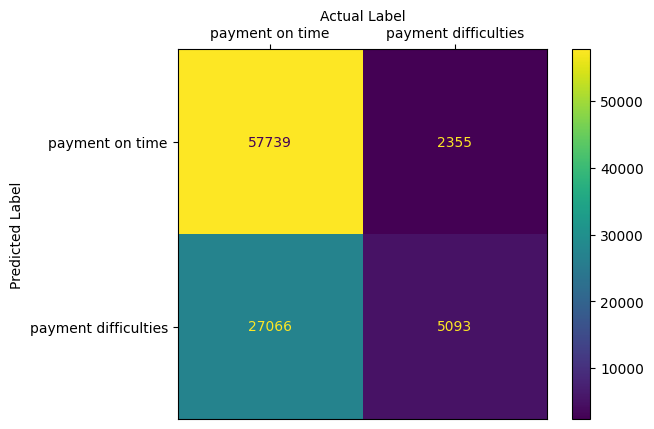

Calcul et affichage du rapport de classification
                      precision    recall  f1-score   support

     payment on time       0.96      0.68      0.80     84805
payment difficulties       0.16      0.68      0.26      7448

            accuracy                           0.68     92253
           macro avg       0.56      0.68      0.53     92253
        weighted avg       0.90      0.68      0.75     92253

Calcul et affichage des différentes métriques
Accuracy : 0.681
Recall : 0.682
AUC : 0.682
Calcul et affichage de la courbe ROC
F1-score : 0.527
Fbeta-score (beta= 10 ) : 0.672


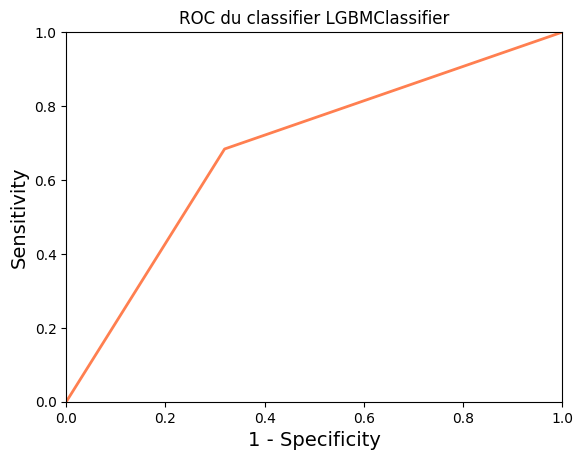

In [85]:
display_confusion_matrix(y_test, y_pred_lgbm, display_labels=target_labels)
display_classification_report(y_test, y_pred_lgbm, display_labels=target_labels)
display_classification_metrics(LGBMModel, X_test_std_select, y_test, y_pred_lgbm, **param_metrics)

## 4) Construction de nouvelles variables

Dans cette partie, nous allons construire de nouvelles variables à partir de celles déjà existantes pour obtenir des variables ayant plus de corrélations avec la Target. Il existe 3 moyens : 
 - Polynomial Features
 - Indicateurs métier
 - Ajout de données extérieures

### a) Polynomial Features

Commençons par la méthode du Polynomial features. Cette méthode consiste à combiner différentes variables entre elles et à les élever à un certains degré polynomial au passage. La méthode va par exemple créer et calculer le résultat de colonnes comme `Y_BIRTH^2`, `EXT_SOURCE_3^2 Y_BIRTH`, `EXT_SOURCE_3^3`... Ensuite, nous étudierons les corrélations entre ces nouvelles variables et la Target.  
Pour notre cas, nous allons utiliser les variables que nous avons vu le plus corrélées avec la target. Nous allons également y ajouter des variables que je trouve pertinentes pour notre étude.

In [86]:
# # La partie suivante est commentée pour éviter le temps d'attente si lancé dans un jupyterlab
# # les résultats sont affichés juste après par des captures d'écran

# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy = 'median')

# # on récupère les données avec les colonnes qui nous intéresse
# poly_features = data[selected_features + ['TARGET']]
# poly_target = poly_features['TARGET']
# poly_features = poly_features.drop(columns = ['TARGET'])

# # on impute des valeurs pour les données manquantes
# poly_features = imputer.fit_transform(poly_features)

# # on instancie la méthode du Polynomial Features
# from sklearn.preprocessing import PolynomialFeatures
# poly_transformer = PolynomialFeatures(degree = 3)

In [87]:
# # on fit et transform nos données pour obtenir toutes nos variables construites
# poly_transformer.fit(poly_features)
# poly_features = poly_transformer.transform(poly_features)

In [88]:
# list_poly_features = poly_transformer.get_feature_names_out(input_features = selected_features)

In [89]:
# # Create a dataframe of the features 
# poly_features = pd.DataFrame(poly_features, columns = poly_transformer.get_feature_names_out(selected_features))

# # Add in the target
# poly_features['TARGET'] = poly_target

# # Find the correlations with the target
# poly_corrs = poly_features.corr()['TARGET'].sort_values()

In [90]:
# print("Top 5 des poly features intervenant négativement :\n", poly_corrs[:5])
# print("Top 5 des poly features intervenant positivement :\n", poly_corrs[-7:-2])

Les résultats de ce traitement peuvent être visible dans les tableaux suivants : 

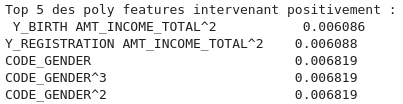

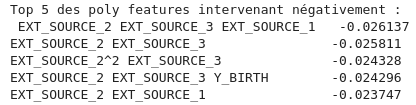

Que ce soit de manière négative ou positive, nous n'avons pas de meilleure corrélation que celle déjà existantes.

### b) Indicateurs métier

N'étant pas du métier, mais ayant déjà contracté un prêt, j'ai choisi de calculer certains indicateurs que je trouve pertinents : 
 - `DEBT_RATE` : le taux d'endettement
 - `PAYMENT_RATE` : la taux de remboursement
 - `Y_REMAIN` : le nombre d'année restante approximatif (approximation ne tenant pas compte du paiement de l'assurance)

In [91]:
neo_var = data.copy()

In [92]:
neo_var['DEBT_PERCENT'] = neo_var['AMT_ANNUITY'] / neo_var['AMT_INCOME_TOTAL'] * 100
neo_var['PAYMENT_RATE'] = neo_var['AMT_ANNUITY'] / neo_var['AMT_CREDIT'] * 100
neo_var['Y_REMAIN'] = neo_var["AMT_CREDIT"] / neo_var["AMT_ANNUITY"]
indicateurs_metiers = ['DEBT_PERCENT', 'PAYMENT_RATE', 'Y_REMAIN']

In [93]:
my_corr = neo_var[indicateurs_metiers + ['TARGET']].corr()['TARGET'].sort_values()
print("Voici les corrélations existantes entre ces nouvelles variables et la target :\n", my_corr.head())

Voici les corrélations existantes entre ces nouvelles variables et la target :
 Y_REMAIN       -0.032102
PAYMENT_RATE    0.012703
DEBT_PERCENT    0.014262
TARGET          1.000000
Name: TARGET, dtype: float64


Là non plus, nous n'avons pas de corrélations fortes à utiliser pour nos investigations durant l'étude des modèles.  
Nous allons cependant les tracer pour étudier leur tendances : 

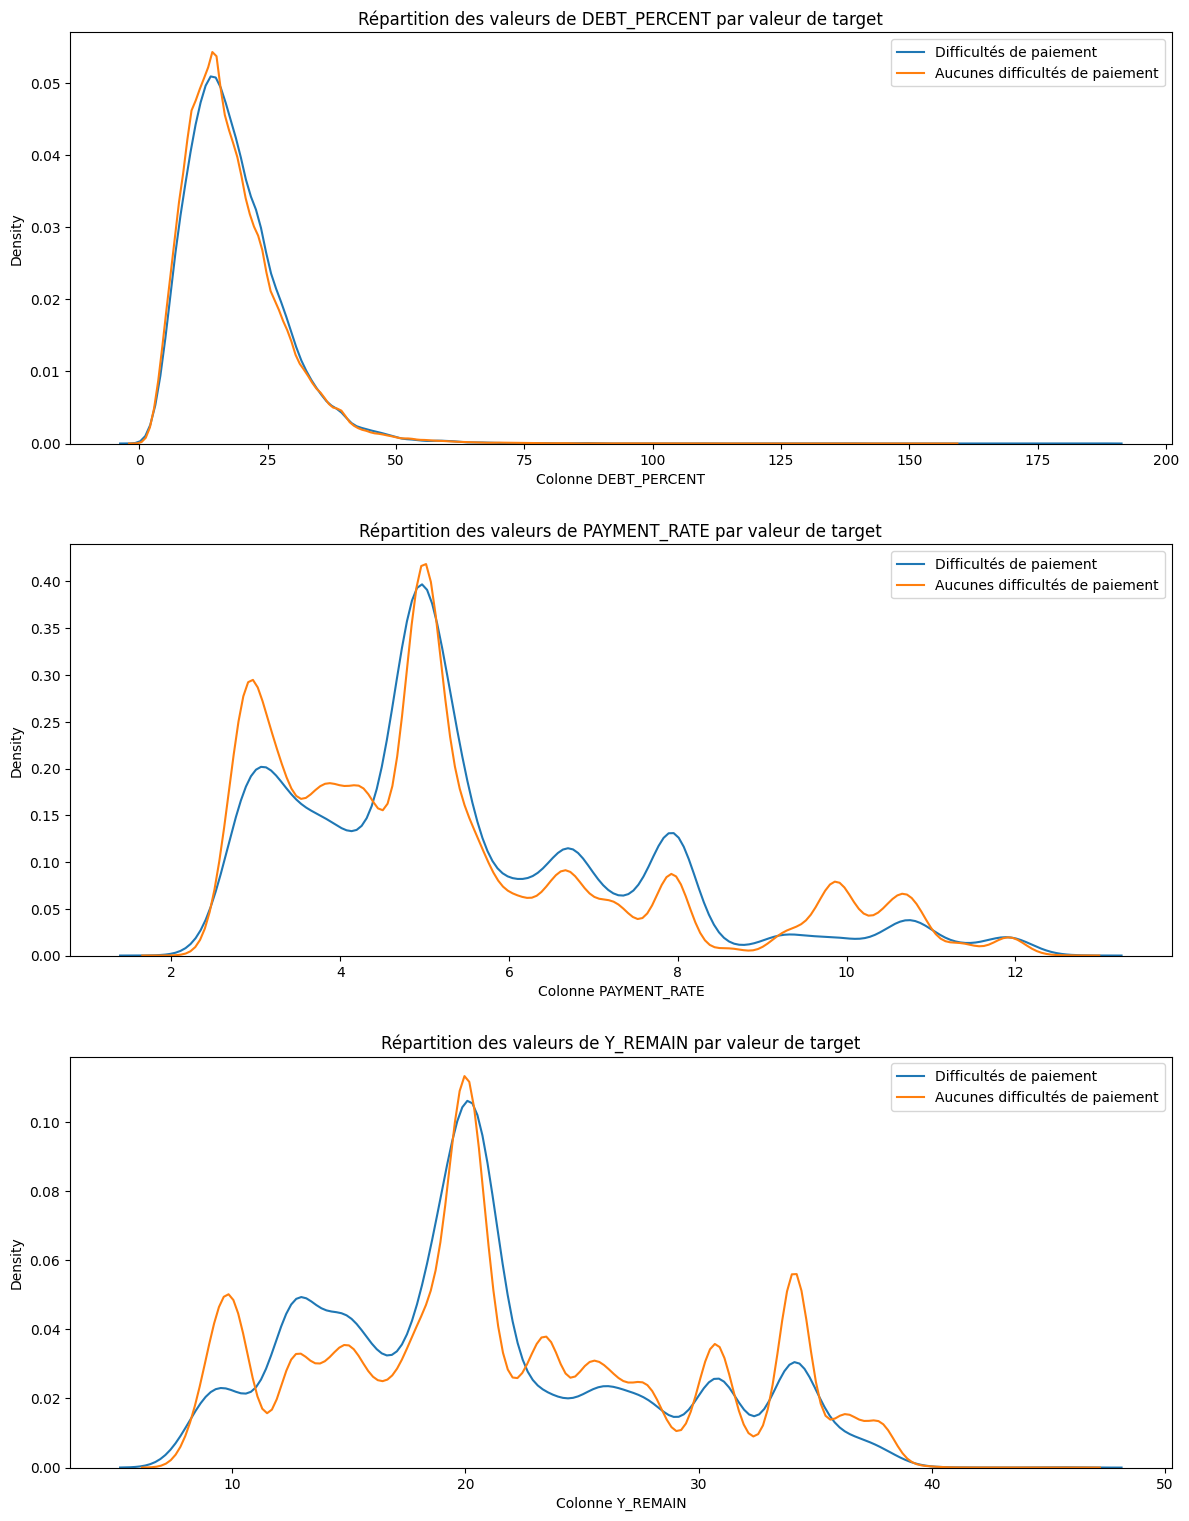

In [94]:
plt.figure(figsize = (12, 20))
for i, feature in enumerate(indicateurs_metiers):
    
    # créer un graph par feature
    plt.subplot(4, 1, i + 1)
    # sur le même graphique, on trace une courbe par valeur de target
    sns.kdeplot(neo_var.loc[neo_var['TARGET'] == 1, feature], label = 'Difficultés de paiement')
    sns.kdeplot(neo_var.loc[neo_var['TARGET'] == 0, feature], label = 'Aucunes difficultés de paiement')
    
    # titres des graph
    plt.title('Répartition des valeurs de {} par valeur de target'.format(feature))
    plt.xlabel("Colonne {}".format(feature))
    plt.legend()
    
plt.tight_layout(h_pad = 2.5)
plt.show()

***
Le taux d'endettement est effectivement indépendant des difficultés à rembourser un crédit. On remarque cependant un pic :

In [95]:
print("à une valeur proche de", round(neo_var['DEBT_PERCENT'].median(), 1), "%.")

à une valeur proche de 16.3 %.


C'est effectivement un taux d'endettement plus bas que pour l'achat d'un logement puisque c'est un crédit à la consommation.

***
Le taux de remboursement est plus intéressant à observer. En effet, la courbe montrant l'absence de difficultés de paiement est plus élevée dans les taux bas (environ 3%) et les taux élevés (autour de 10%). En revanche, des taux de remboursement autour de 5% sont d'une part plus commun, d'autre part aucunement corrélés avec les difficultés de paiement.

***
On observe une tendance similaire sur le nombre d'année de remboursement restant. Lorsqu'il reste peu de temps (10 ans), ou beaucoup de temps (35 ans), l'absence de difficultés de paiement est plus marquée. En revanche, pour des temps plus commun (20 ans), il n'y a aucune corrélation avec les difficultés de paiement.

### c) Ajout de données extérieures

Dans notre projet, nous avons également d'autres données dans différents fichiers csv. Nous allons nous attarder en particulier sur les données en rapport avec le comportement du client. Nous allons donc utiliser les fichiers POS_CASH_balance.csv et credit_card_balance.csv.

In [96]:
pos = pos_cash()
print("Le fichier POS_CASH_balance.csv ajoute", pos.shape[1], "colonnes à notre dataset.")
data_w_pos_cash = data_selected.join(pos, how='left', on='SK_ID_CURR')
del pos
gc.collect()

Le fichier POS_CASH_balance.csv ajoute 18 colonnes à notre dataset.


0

In [97]:
cc = credit_card_balance()
print("Le fichier credit_card_balance.csv ajoute", cc.shape[1], "colonnes à notre dataset.")
data_aggr = data_w_pos_cash.join(cc, how='left', on='SK_ID_CURR')
del cc
gc.collect()

Le fichier credit_card_balance.csv ajoute 141 colonnes à notre dataset.


0

In [98]:
print("Après avoir chargé les 2 fichiers, notre dataset présente maintenant", data_aggr.shape[0], "lignes et", data_aggr.shape[1], "colonnes.")

Après avoir chargé les 2 fichiers, notre dataset présente maintenant 307507 lignes et 173 colonnes.


***
### Corrélation entre variables

In [99]:
# extraire les variables étant très corrélées > 0.8
list_col_num = data_aggr.columns.tolist()
corr = data_aggr.corr().values
nb_col = len(list_col_num)
nb_correl = 0
list_col_stat_correl = []
for i in range(nb_col):
    for j in range(i+1, nb_col):
        if abs(corr[i,j]) >= 0.9:
            print(list_col_num[i], ' ', list_col_num[j], ' ', corr[i,j])
            nb_correl += 1
                
print("Il reste", nb_correl, "paires de corrélation.")

POS_MONTHS_BALANCE_SIZE   POS_COUNT   1.0
POS_SK_DPD_MAX   POS_SK_DPD_MEAN   0.9243574498322494
POS_SK_DPD_DEF_MAX   POS_SK_DPD_DEF_MEAN   0.9648637462496974
CC_MONTHS_BALANCE_MIN   CC_MONTHS_BALANCE_MEAN   0.9996522911186942
CC_MONTHS_BALANCE_MIN   CC_MONTHS_BALANCE_SUM   0.9819298137689707
CC_MONTHS_BALANCE_MIN   CC_MONTHS_BALANCE_VAR   -0.9815046815765102
CC_MONTHS_BALANCE_MIN   CC_NAME_CONTRACT_STATUS_Active_SUM   -0.989962428808552
CC_MONTHS_BALANCE_MIN   CC_COUNT   -0.9993747201218596
CC_MONTHS_BALANCE_MEAN   CC_MONTHS_BALANCE_SUM   0.9811600368422887
CC_MONTHS_BALANCE_MEAN   CC_MONTHS_BALANCE_VAR   -0.980284287285518
CC_MONTHS_BALANCE_MEAN   CC_NAME_CONTRACT_STATUS_Active_SUM   -0.9890095160478206
CC_MONTHS_BALANCE_MEAN   CC_COUNT   -0.9981953354226176
CC_MONTHS_BALANCE_SUM   CC_MONTHS_BALANCE_VAR   -0.9996305367102885
CC_MONTHS_BALANCE_SUM   CC_NAME_CONTRACT_STATUS_Active_SUM   -0.9706649208221536
CC_MONTHS_BALANCE_SUM   CC_COUNT   -0.9819653510880648
CC_MONTHS_BALANCE_VAR   CC

***
### Corrélations avec la target

In [100]:
col_corr_target = get_corr_target_var(data_aggr, top=15)

Calcul des corrélations entre la target et les autres variables

Il y a 33 variables participant positivement à la target. Voici le top 15 :


,TARGET
CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,0.107692
CC_CNT_DRAWINGS_CURRENT_MAX,0.101389
CC_AMT_BALANCE_MEAN,0.087177
CC_AMT_TOTAL_RECEIVABLE_MEAN,0.086490
CC_AMT_RECIVABLE_MEAN,0.086478
CC_AMT_RECEIVABLE_PRINCIPAL_MEAN,0.086062
CC_CNT_DRAWINGS_CURRENT_MEAN,0.082520
CC_AMT_INST_MIN_REGULARITY_MEAN,0.073724
CC_CNT_DRAWINGS_POS_CURRENT_MAX,0.068942
CC_AMT_BALANCE_MAX,0.068798


Il y a 13 variables participant négativement à la target. Voici le top 13 :


,TARGET
EXT_SOURCE_3,-0.178926
EXT_SOURCE_2,-0.160471
EXT_SOURCE_1,-0.155317
Y_BIRTH,-0.078242
CC_COUNT,-0.060481
CC_NAME_CONTRACT_STATUS_Active_SUM,-0.059376
CC_MONTHS_BALANCE_VAR,-0.058817
NAME_EDUCATION_TYPE_Higher education,-0.056593
Y_ID_PUBLISH,-0.051457
Y_EMPLOYED,-0.046050


Et voici le top 15 de la liste complète :


,TARGET
EXT_SOURCE_3,0.178926
EXT_SOURCE_2,0.160471
EXT_SOURCE_1,0.155317
CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,0.107692
CC_CNT_DRAWINGS_CURRENT_MAX,0.101389
CC_AMT_BALANCE_MEAN,0.087177
CC_AMT_TOTAL_RECEIVABLE_MEAN,0.086490
CC_AMT_RECIVABLE_MEAN,0.086478
CC_AMT_RECEIVABLE_PRINCIPAL_MEAN,0.086062
CC_CNT_DRAWINGS_CURRENT_MEAN,0.082520


***
### Utilisation de notre modèle optimisé  
Regardons maintenant l'impact des ces nouvelles colonnes sur le modèle optimisé.

In [101]:
X = data_aggr.loc[:, data_aggr.columns != "TARGET"]
y = data_aggr["TARGET"]

# puis on split à nouveau
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # stratify pour avoir meme répartition de target

In [102]:
#  on impute et on scale à nouveau
X_train_std, X_test_std = impute_and_scale(X_train, X_test)

In [103]:
from lightgbm import LGBMClassifier
param_lgbm = {
    'learning_rate': 0.05, 'max_depth': 5, 'min_child_samples': 10,
    'n_estimators': 100, 'num_leaves': 20, 'reg_alpha': 0.03
}
LGBMModel_csv = LGBMClassifier(**param_lgbm, class_weight="balanced")

In [104]:
LGBMModel_csv.fit(X_train_std, y_train)

LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=5,
               min_child_samples=10, num_leaves=20, reg_alpha=0.03)

In [105]:
y_pred_lgbm = LGBMModel_csv.predict(X_test_std)

Calcul et affichage de la matrice de confusion


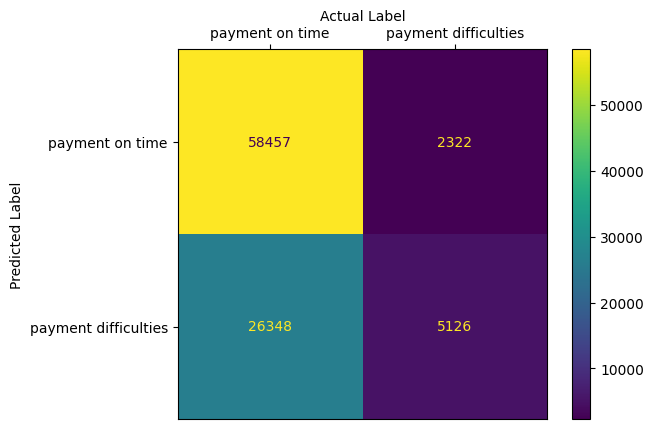

Calcul et affichage du rapport de classification
                      precision    recall  f1-score   support

     payment on time       0.96      0.69      0.80     84805
payment difficulties       0.16      0.69      0.26      7448

            accuracy                           0.69     92253
           macro avg       0.56      0.69      0.53     92253
        weighted avg       0.90      0.69      0.76     92253

Calcul et affichage des différentes métriques
Accuracy : 0.689
Recall : 0.689
AUC : 0.689
Calcul et affichage de la courbe ROC
F1-score : 0.533
Fbeta-score (beta= 10 ) : 0.679


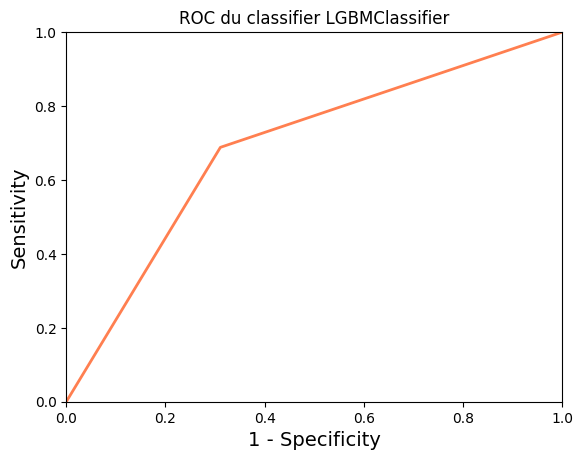

In [106]:
display_confusion_matrix(y_test, y_pred_lgbm, display_labels=target_labels)
display_classification_report(y_test, y_pred_lgbm, display_labels=target_labels)
display_classification_metrics(LGBMModel_csv, X_test_std, y_test, y_pred_lgbm, **param_metrics)

***
### Feature importance

Voici le top 14 des features ayant le plus d'impact sur le modèle.


,feature,importance
2,EXT_SOURCE_1,224
1,EXT_SOURCE_3,223
0,EXT_SOURCE_2,187
6,Y_BIRTH,121
4,AMT_CREDIT,117
7,Y_EMPLOYED,105
3,AMT_ANNUITY,73
19,POS_SK_DPD_DEF_MEAN,68
5,Y_ID_PUBLISH,64
98,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,61


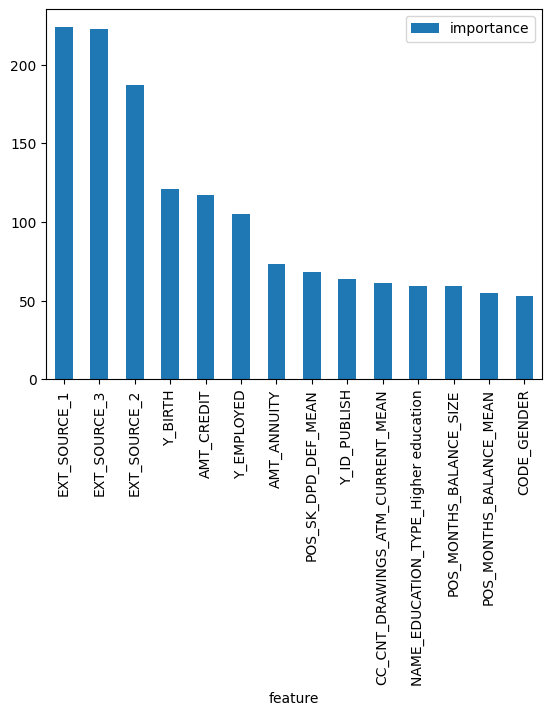

In [107]:
features = [x for x in list(data_aggr.columns) if x != 'TARGET']
display_feature_importance('LGBM', LGBMModel_csv, features, top=15, threshold=[0.015, 50])

In [108]:
# selected_features_2 = [
#     'EXT_SOURCE_1', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'Y_BIRTH', 'AMT_CREDIT', 'Y_EMPLOYED', 'AMT_ANNUITY',
#     'POS_SK_DPD_DEF_MEAN', 'Y_ID_PUBLISH', 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN',
#     'NAME_EDUCATION_TYPE_Higher education', 'POS_MONTHS_BALANCE_SIZE', 'POS_MONTHS_BALANCE_MEAN', 'CODE_GENDER'
# ]

In [109]:
# data_selected_2 = data_aggr.loc[:, selected_features_2 + ['TARGET', 'SK_ID_CURR']]
# X_select = data_selected_2.loc[:, data_selected_2.columns != "TARGET"]

In [110]:
# X_train_select, X_test_select, y_train, y_test = train_test_split(X_select, y, test_size=0.3, random_state=42, stratify=y) # stratify pour avoir meme répartition de target

In [111]:
# #  on impute et on scale à nouveau
# X_train_std_select, X_test_std_select = impute_and_scale(X_train_select, X_test_select)

In [112]:
# # code commenté pour éviter la longue attente
# param_lgbm = {
#     'learning_rate': 0.05, 'max_depth': 5, 'min_child_samples': 10,
#     'n_estimators': 100, 'num_leaves': 20, 'reg_alpha': 0.03
# }
# LGBMModel = LGBMClassifier(**param_lgbm, class_weight="balanced")

In [113]:
# LGBMModel.fit(X_train_std_select, y_train)

In [114]:
# y_pred_lgbm = LGBMModel.predict(X_test_std_select)

In [115]:
# display_confusion_matrix(y_test, y_pred_lgbm, display_labels=target_labels)
# display_classification_report(y_test, y_pred_lgbm, display_labels=target_labels)
# display_classification_metrics(LGBMModel, X_test_std_select, y_test, y_pred_lgbm, **param_metrics)

***
### PCA

In [116]:
# pour utiliser la méthode du PCA et afficher l'éboulis des inerties entre les variables
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
def compute_pca(df, n_components=2):
    result = pd.DataFrame()
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    # split des données
    X = df.values
    names = df.index
    features = df.columns
    
    print("L'échantillon présente", df.shape[0], "lignes et", df.shape[1], "colonnes")
    # vérif n_components
    if n_components > min(len(df), len(features)):
        print("Le nombre de composantes est trop élevée. On le recale à la valeur maximale.")
        print("La nouvelle valeur sera le minimum entre le nombre de ligne dans l'échantillon et le nombre de features, càd", min(len(df), len(features)))
        n_components = min(len(df), len(features))
    
    scaler = StandardScaler() # instance de scaler
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA(n_components=n_components) # instance de PCA
    pca.fit(X_scaled) # entrainement sur les données scalées
    
    # print("Valeurs propres (mieux si > 1):", pca.explained_variance_)
    print("Une méthode consiste à dire que l'on garde uniquement les valeurs propres supérieures à 1.")
    nb_opti_val_p = [x for x in pca.explained_variance_ if x >= 0.9]
    print("Ici, la méthode des valeurs propres nous demande de garder", len(nb_opti_val_p), "composantes.")
    # print("Variance ratio", pca.explained_variance_ratio_)
    
    # tracé de l'éboulis des valeurs propres
    scree = (pca.explained_variance_ratio_*100).round(2)
    scree_cum = scree.cumsum().round()
    print("La méthode principale consiste à dire que l'on garde uniquement les composantes qui regroupent 95% des variables.")
    nb_opti_95_inertie = len([x for x in scree_cum if x <= 95])
    print("Ici, la méthode des 95% d'inertie nous demande de garder", nb_opti_95_inertie, "composantes.")
    
    x_list = range(1, n_components+1)
    plt.bar(x_list, scree)
    plt.plot(x_list, scree_cum, c="red", marker='o')
    plt.xticks(np.arange(0, n_components+1, 2))
    plt.xlabel("Rang de l'axe d'inertie")
    plt.ylabel("Pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    
    # pour afficher les lignes de 95% et de nombre de composantes optimal
    min_ylim, max_ylim = plt.ylim()
    min_xlim, max_xlim = plt.xlim()
    plt.axvline(nb_opti_95_inertie, color='k', linestyle='dashed', linewidth=1)
    plt.text(nb_opti_95_inertie, max_ylim*0.85, ' {:.0f} composantes'.format(nb_opti_95_inertie))
    plt.axhline(95, color='k', linestyle='dashed', linewidth=1)
    plt.text(max_xlim*0.55, 95+2, "95 % d'inertie")
    
    plt.show(block=False)
    
    return pca

In [117]:
def show_components_heatmap(df, pca):
    result = pd.DataFrame()
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    pcs = pca.components_
    pcs = pd.DataFrame(pcs)
    pcs.columns = df.columns # features
    n_components = len(pcs)
    x_list = range(1, n_components+1)
    pcs.index = [f"F{i}" for i in x_list]
    pcs.round(2)
    # représentation visuelle
    gif, ax = plt.subplots(figsize=(20, 10))
    sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")
    return pcs


In [118]:
def compute_components(pcs, threshold=0.6):
    result = []
    for index, row in pcs.iterrows():
        for col in pcs.columns:
            if abs(row[col]) >= threshold:
                print(col, ":", row[col])
                result.append(col)
    
    result = list(set(result))
    print("Il y a", len(result), "variables ayant un impact conséquent sur les composantes.")
    print("Voici la liste :", result)
    return result

In [119]:
# # from sklearn.impute import SimpleImputer
# data_aggr_cp = data_aggr.copy()
# imputer = SimpleImputer(strategy = 'median')
# imputer.fit(data_aggr_cp)
# data_aggr_cp = imputer.transform(data_aggr_cp)

In [120]:
# data_aggr_cp_df = pd.DataFrame(data_aggr_cp, columns=data_aggr.columns)

In [121]:
# # tracé de l'éboulis des valeurs propres
# pca = compute_pca(data_aggr_cp_df[selected_features_2], 12)

In [122]:
# # heatmap de corrlation entre les variables et les composantes
# pcs = show_components_heatmap(data_aggr_cp_df[selected_features_2], pca)

In [123]:
# # on parcourt toutes les lignes et on relève toutes les variables ayant une "importance" (> 0.65) dans une composante
# reduc_var = compute_components(pcs, threshold=0.4)

# VI) Explications des variables

## 1) LIME

In [124]:
# # on sélectionne nos données avec les variables sélectionnées
# data_selected = data.loc[:, selected_features + ['TARGET', 'SK_ID_CURR']]
# X_select = data_selected.loc[:, data_selected.columns != "TARGET"]
# y = data_selected["TARGET"]
# # X_select = data.loc[:, selected_features]

# # puis on split à nouveau
# X_train_select, X_test_select, y_train, y_test = train_test_split(X_select, y, test_size=0.3, random_state=42, stratify=y) # stratify pour avoir meme répartition de target

In [125]:
# X_train_std_select, X_test_std_select = impute_and_scale(X_train_select, X_test_select)

In [126]:
target_names = np.array(y.unique())
feature_names = np.array([x for x in data_selected.columns if x != 'TARGET'])

In [128]:
data_selected.shape

(307507, 14)

In [141]:
from lime import lime_tabular
explainer = lime_tabular.LimeTabularExplainer(
    X_train_std_select, mode="classification",
    class_names=['difficulties', 'on time'],
    feature_names=feature_names)
explainer

In [142]:
import random
idx = random.randint(1, len(X_test_std_select))

# print("Prediction : ", target_names[LGBMModel.predict(X_test_std_select[idx].reshape(1,-1))[0]])
# print("Actual :     ", target_names[y_test[idx+1]])

explanation = explainer.explain_instance(X_test_std_select[24145], LGBMModel.predict_proba, num_features=len(feature_names))
explanation.show_in_notebook()

In [169]:
# class 1 : idx = 24145

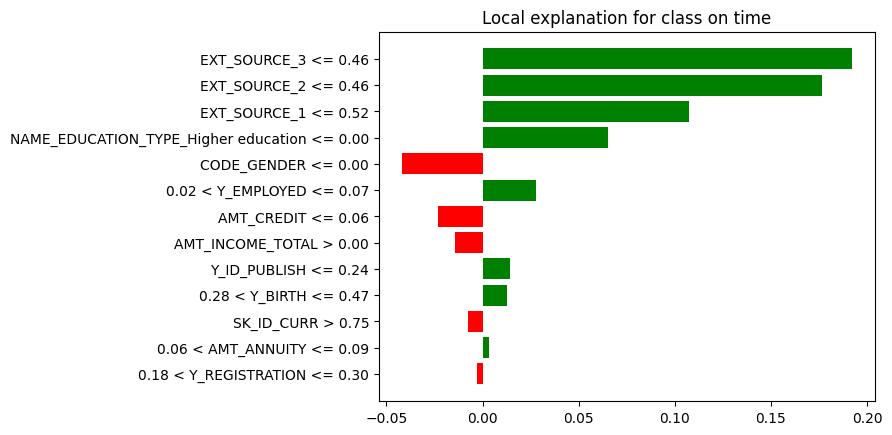

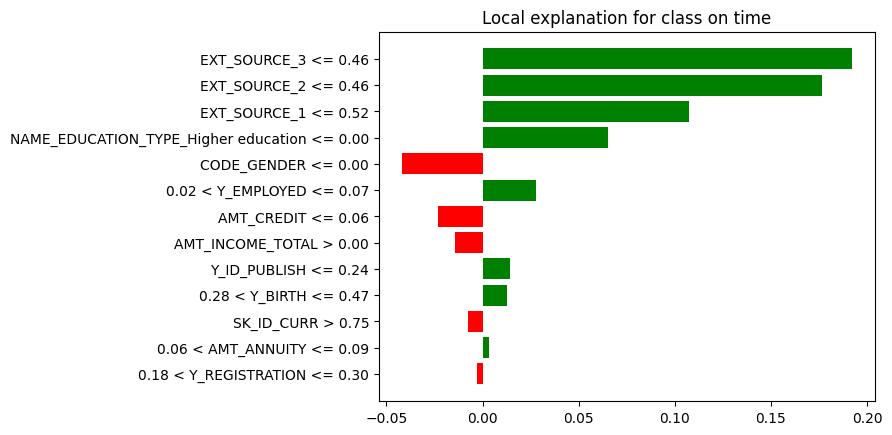

In [170]:
explanation.as_pyplot_figure()

## 2) SHAP

In [149]:
import shap
lgbm_explainer = shap.TreeExplainer(LGBMModel)

In [156]:
shap_values = lgbm_explainer.shap_values(X_train_std_select)

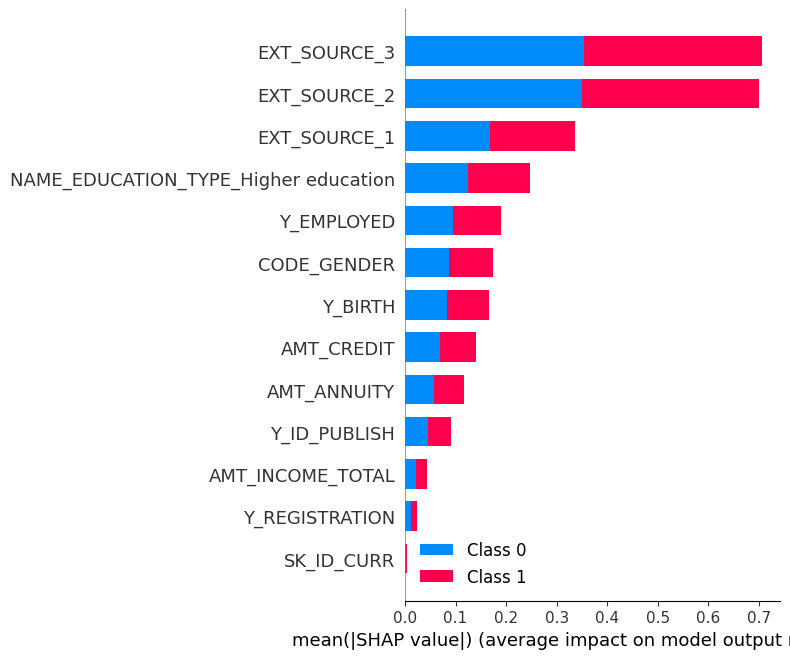

In [157]:
shap.summary_plot(shap_values, X_train_std_select, feature_names=feature_names, max_display=len(feature_names))

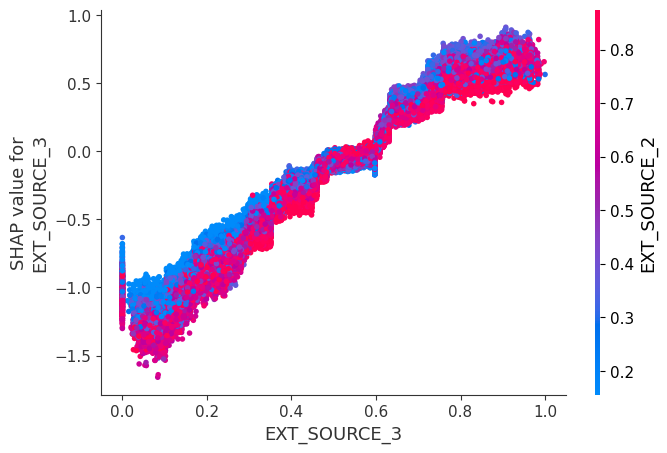

In [167]:
shap.dependence_plot("EXT_SOURCE_3", shap_values[0], X_train_std_select, feature_names=feature_names)

# VII) Conclusion